In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, PowerTransformer 

from custom_classes_and_functions import SimpleImputerWrapper
import pickle

In [2]:
sns.set()
pd.set_option('display.max_colwidth', 500)
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:20,.3f}'.format

Read in all the necessary data and make them ready for the exploratory analysis.

In [3]:
train_data = pd.read_csv('train_data_raw.csv', low_memory=False)

with open('Data/data_dict.pkl', 'rb') as file:
    data_dict = pickle.loads(file.read())

with open('Data/dataframe_operations_01.pkl', 'rb') as file:
    dataframe_operations = pickle.loads(file.read())

In [4]:
data_dict = \
    data_dict.loc[~data_dict['column_name'].\
                  isin(dataframe_operations['columns_to_drop']), :]
data_dict = data_dict.reset_index(drop=True)

train_eda = train_data[data_dict['column_name']]

In [5]:
data_dict

column_name  \
0            annual_inc   
1                   dti   
2      earliest_cr_line   
3            emp_length   
4        home_ownership   
5   initial_list_status   
6           installment   
7              int_rate   
8   verification_status   
9             loan_amnt   
10          loan_status   
11             open_acc   
12              pub_rec   
13              purpose   
14            revol_bal   
15           revol_util   
16                 term   
17             zip_code   
18     total_rev_hi_lim   

                                                                                                                                                                                                 description  
0                                                                                                                              The self-reported annual income provided by the borrower during registration.  
1   A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.  
2                                                                                                                                          The month the borrower's earliest reported credit line was opened  
3                                                                         Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.   
4                                                                                        The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.  
5                                                                                                                                         The initial listing status of the loan. Possible values are – W, F  
6                                                                                                                                           The monthly payment owed by the borrower if the loan originates.  
7                                                                                                                                                                                  Interest Rate on the loan  
8                                                                                                                 Indicates if income was verified by LC, not verified, or if the income source was verified  
9                               The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.  
10                                                                                                                                                                                Current status of the loan  
11                                                                                                                                            The number of open credit lines in the borrower's credit file.  
12                                                                                                                                                                       Number of derogatory public records  
13                                                                                                                                                A category provided by the borrower for the loan request.   
14                                                                                                                                                                            Total credit revolving balance  
15                                                                                Revolving line utilization rate, or the amount of credit the borrower is usin

## Part 1 - Categorical Predictors ##

Let's acquaint ourselves with the potential categorical predictors.

For the purpose of this exploratory data analysis, we start by performing some featue engineering on the selected columns <br> in order to enlarge the collection of the categorical variables.

In [6]:
train_feat_eng = train_data.loc[:, dataframe_operations['columns_to_engineer']].copy()

# New features:

# 1
train_feat_eng['descr_included'] = train_feat_eng['desc'].notnull().astype('object')

# 2
train_feat_eng['zip_1'] = train_feat_eng['zip_code'].apply(lambda x: int(x[:1])).\
                                                     astype('category')

# 3
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

train_feat_eng['ecl_month'] = train_feat_eng['earliest_cr_line'].apply(lambda x: x[:3])
train_feat_eng['ecl_month'] = pd.Categorical(train_feat_eng['ecl_month'], 
                                             categories=ordered_months)

# 4
train_feat_eng['ecl_year'] = train_feat_eng['earliest_cr_line'].apply(lambda x: int(x[4:]))

# 5
index_1970 = train_feat_eng['ecl_year'] < 1970
index_1980 = train_feat_eng['ecl_year'].between(1970, 1979)
index_1990 = train_feat_eng['ecl_year'].between(1980, 1989)
index_2000 = train_feat_eng['ecl_year'].between(1990, 1999)
index_201x = train_feat_eng['ecl_year'] >= 2000

train_feat_eng['ecl_period'] = train_feat_eng['ecl_year']
train_feat_eng.loc[index_1970, 'ecl_period'] = "<1970"
train_feat_eng.loc[index_1980, 'ecl_period'] = "1970-1979"
train_feat_eng.loc[index_1990, 'ecl_period'] = "1980-1989"
train_feat_eng.loc[index_2000, 'ecl_period'] = "1990-1999"
train_feat_eng.loc[index_201x, 'ecl_period'] = ">=2000"

ordered_periods = ["<1970", "1970-1979", "1980-1989", "1990-1999", ">=2000"]

train_feat_eng['ecl_period'] = pd.Categorical(train_feat_eng['ecl_period'],
                                              categories=ordered_periods)

# ecl_year will be converted into numeric dtype in due time
train_feat_eng['ecl_year'] = train_feat_eng['ecl_year'].astype('object')

columns_to_drop = dataframe_operations['columns_to_engineer']
train_feat_eng = train_feat_eng.drop(columns=columns_to_drop)
train_feat_eng.head()

descr_included zip_1 ecl_month ecl_year ecl_period
0           True     8       Jan     1985  1980-1989
1           True     3       Apr     1999  1990-1999
2          False     6       Nov     2001     >=2000
3           True     9       Feb     1996  1990-1999
4          False     8       Nov     2004     >=2000

We can also display some statistics.

In [7]:
train_eda_obj = train_eda.select_dtypes(include=['object']).copy()

set_A = set(train_eda_obj.columns)
set_B = set(dataframe_operations['columns_to_engineer'])
columns_to_drop = list(set_A.intersection(set_B))

train_eda_obj = train_eda_obj.drop(columns=columns_to_drop)
train_eda_obj = pd.concat([train_eda_obj, train_feat_eng], axis=1)

train_eda_obj_stats = train_eda_obj.describe().T.iloc[:, 1:]
train_eda_obj_stats = pd.concat([train_eda_obj.isnull().sum(),
                                 train_eda_obj_stats], axis=1, sort=False)
train_eda_obj_stats.columns = ['null_count'] + train_eda_obj_stats.columns.values.\
                                                                   tolist()[1:]
train_eda_obj_stats
train_eda_obj_stats.sort_values(by=['unique'])

null_count unique                 top    freq
initial_list_status           0      2                   f  182079
term                          0      2           36 months  196658
descr_included                0      2               False  164652
verification_status           0      3            Verified   92896
ecl_period                    0      5              >=2000  115772
home_ownership                0      6            MORTGAGE  124844
zip_1                         0     10                   9   54520
emp_length                 9897     11           10+ years   76881
ecl_month                     0     12                 Oct   24688
purpose                       0     14  debt_consolidation  148363
ecl_year                      0     62                2000   20077

Now, we are going to look at the distribution of the bad loan percentage values with respect to each categorical variable to gain insight into the strength of individual predictors (measured by the absolute differences in the aforementioned percentages among various categories).

In [8]:
# Add loan_status for technical reasons
train_eda_obj = pd.concat([train_eda_obj, train_data['loan_status']], axis=1)

In [9]:
def get_bad_loan_pct_by_category_01(df, column_list, category_list=[], 
                                     agg_func_list=['mean', 'count'], fig_size=(10, 6)):

    agg_column = column_list[0]
    df_agg = df[column_list].groupby(agg_column).agg(agg_func_list)
    df_agg.columns = df_agg.columns.droplevel(0)
    
    # Turn into a percentage
    if 'mean' in agg_func_list:
        df_agg['mean'] *= 100
    
    df_agg = df_agg.round(3).reset_index()
    
    df_agg.rename(
        columns=lambda col_name: 'bad_loan_pct' if col_name == 'mean' else col_name, 
        inplace=True
    )
    df_agg.rename(
        columns=lambda col_name: 'loan_count' if col_name == 'count' else col_name, 
        inplace=True
    )
    
    plt.figure(figsize=fig_size)
    sns.pointplot(data=df_agg, x=agg_column , y='bad_loan_pct', color='b')
    plt.title('Bad Loan Percentage per Category')
    plt.show()
    
    return df_agg

**Loan Initial Listing Status**

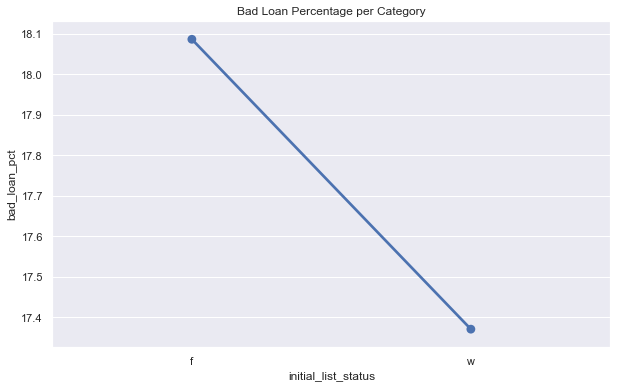

initial_list_status         bad_loan_pct  loan_count
0                   f               18.087      182079
1                   w               17.371       70892

In [10]:
column_list = ['initial_list_status', 'loan_status']
category_list = np.sort(
    train_eda_obj[column_list[0]].value_counts().index.values).tolist()

get_bad_loan_pct_by_category_01(train_eda_obj, column_list)

**Loan Term**

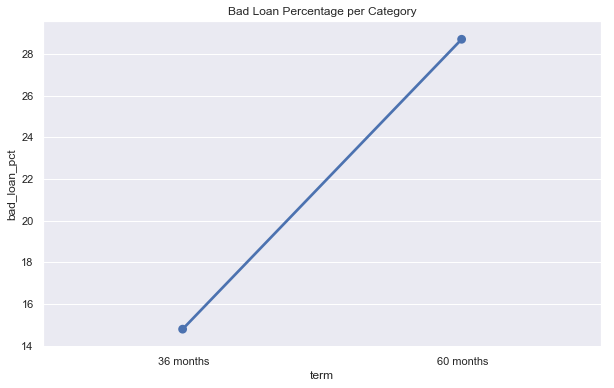

term         bad_loan_pct  loan_count
0   36 months               14.789      196658
1   60 months               28.706       56313

In [11]:
column_list = ['term', 'loan_status']
category_list = np.sort(
    train_eda_obj[column_list[0]].value_counts().index.values).tolist()

get_bad_loan_pct_by_category_01(train_eda_obj, column_list)

**Is Description Included**

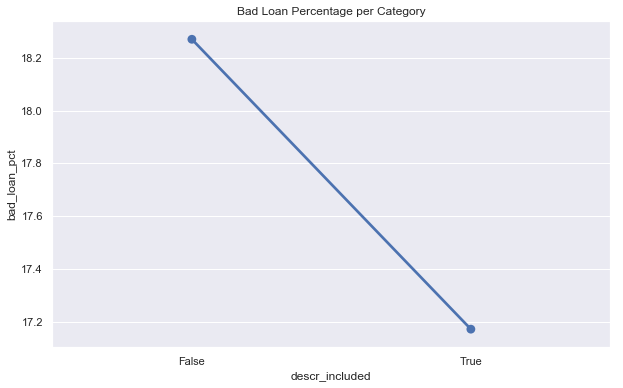

descr_included         bad_loan_pct  loan_count
0           False               18.270      164652
1            True               17.172       88319

In [12]:
column_list = ['descr_included', 'loan_status']
category_list = np.sort(
    train_eda_obj[column_list[0]].value_counts().index.values).tolist()

get_bad_loan_pct_by_category_01(train_eda_obj, column_list)

**Verification Status**

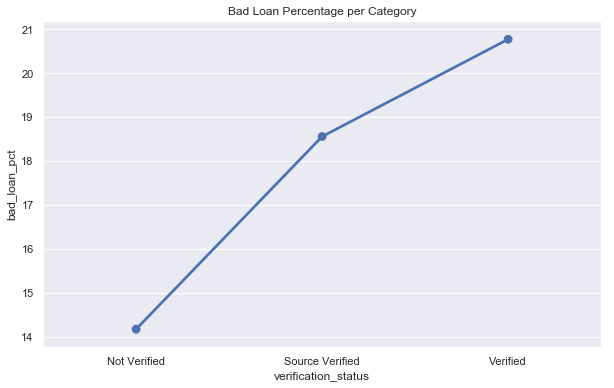

verification_status         bad_loan_pct  loan_count
0        Not Verified               14.185       86064
1     Source Verified               18.565       74011
2            Verified               20.776       92896

In [13]:
column_list = ['verification_status', 'loan_status']
category_list = np.sort(
    train_eda_obj[column_list[0]].value_counts().index.values).tolist()

get_bad_loan_pct_by_category_01(train_eda_obj, column_list)

**Month of Earliest Reported Credit Line Opened**

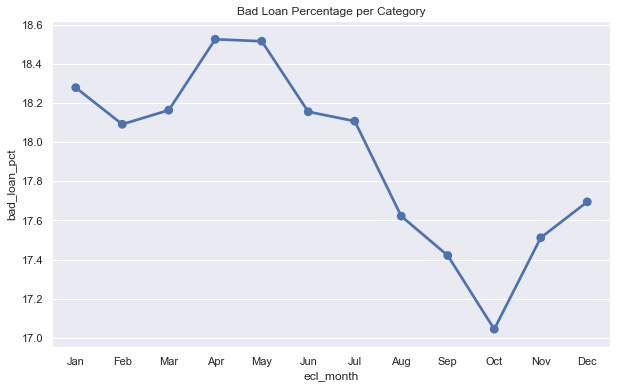

ecl_month         bad_loan_pct  loan_count
0        Jan               18.278       20626
1        Feb               18.091       18506
2        Mar               18.163       19738
3        Apr               18.525       18348
4        May               18.515       19292
5        Jun               18.155       19245
6        Jul               18.107       20301
7        Aug               17.622       22932
8        Sep               17.421       23489
9        Oct               17.045       24688
10       Nov               17.512       23184
11       Dec               17.695       22622

In [14]:
column_list = ['ecl_month', 'loan_status']
category_list = np.sort(
    train_eda_obj[column_list[0]].value_counts().index.values).tolist()

get_bad_loan_pct_by_category_01(train_eda_obj, column_list, category_list)

**Period of Earliest Reported Credit Line Opened**

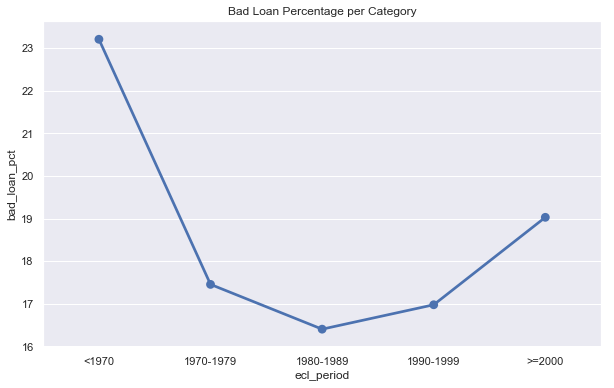

ecl_period         bad_loan_pct  loan_count
0      <1970               23.212         685
1  1970-1979               17.457        4955
2  1980-1989               16.406       25710
3  1990-1999               16.979      105849
4     >=2000               19.032      115772

In [15]:
column_list = ['ecl_period', 'loan_status']
category_list = np.sort(
    train_eda_obj[column_list[0]].value_counts().index.values).tolist()

get_bad_loan_pct_by_category_01(train_eda_obj, column_list)

**Home Ownership**

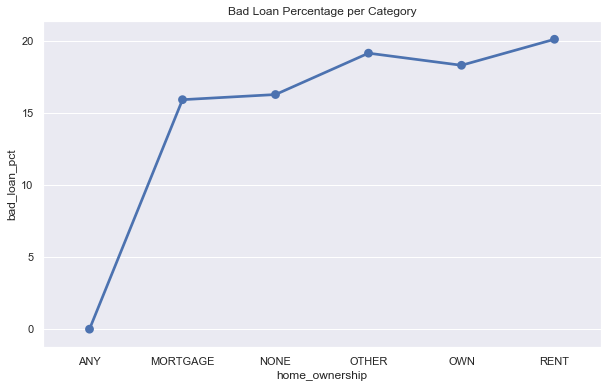

home_ownership         bad_loan_pct  loan_count
0            ANY                0.000           1
1       MORTGAGE               15.922      124844
2           NONE               16.279          43
3          OTHER               19.149         141
4            OWN               18.308       21985
5           RENT               20.113      105957

In [16]:
column_list = ['home_ownership', 'loan_status']
category_list = np.sort(
    train_eda_obj[column_list[0]].value_counts().index.values).tolist()

get_bad_loan_pct_by_category_01(train_eda_obj, column_list)

**First Digit of Zip Code**

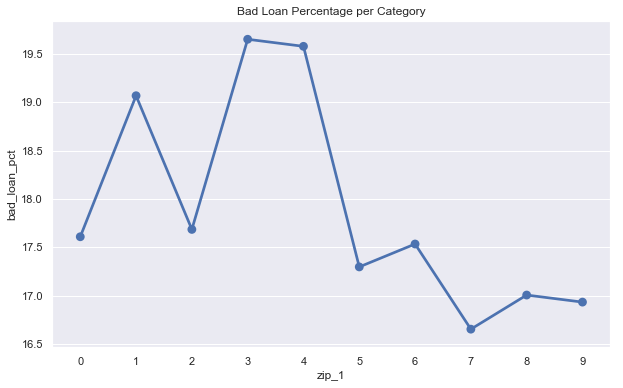

zip_1         bad_loan_pct  loan_count
0     0               17.609       22119
1     1               19.068       30370
2     2               17.685       25672
3     3               19.652       31570
4     4               19.579       18811
5     5               17.297        8834
6     6               17.534       15307
7     7               16.653       26181
8     8               17.006       19587
9     9               16.933       54520

In [17]:
column_list = ['zip_1', 'loan_status']
category_list = np.sort(
    train_eda_obj[column_list[0]].value_counts().index.values).tolist()

get_bad_loan_pct_by_category_01(train_eda_obj, column_list)

**Employment Length**

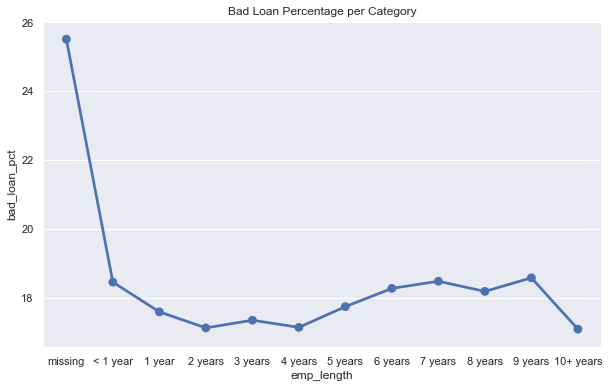

emp_length         bad_loan_pct  loan_count
0     missing               25.513        9897
1    < 1 year               18.448       20886
2      1 year               17.584       16856
3     2 years               17.117       23561
4     3 years               17.341       20380
5     4 years               17.133       16197
6     5 years               17.736       18059
7     6 years               18.267       14753
8     7 years               18.474       14085
9     8 years               18.179       11849
10    9 years               18.574        9567
11  10+ years               17.082       76881

In [18]:
column_list = ['emp_length', 'loan_status']
tmp = train_data.loc[:, column_list].copy()

indx_null = tmp['emp_length'].isnull()
tmp.loc[indx_null, 'emp_length'] = 'missing'

category_list = np.sort(tmp['emp_length'].value_counts().index.values).tolist()
category_list = [category_list[-1]] + [category_list[-2]] + [category_list[0]] + \
                 category_list[2:-2] + [category_list[1]]
    
tmp['emp_length'] = pd.Categorical(tmp['emp_length'], categories=category_list)

get_bad_loan_pct_by_category_01(tmp, column_list)

**Loan Purpose**

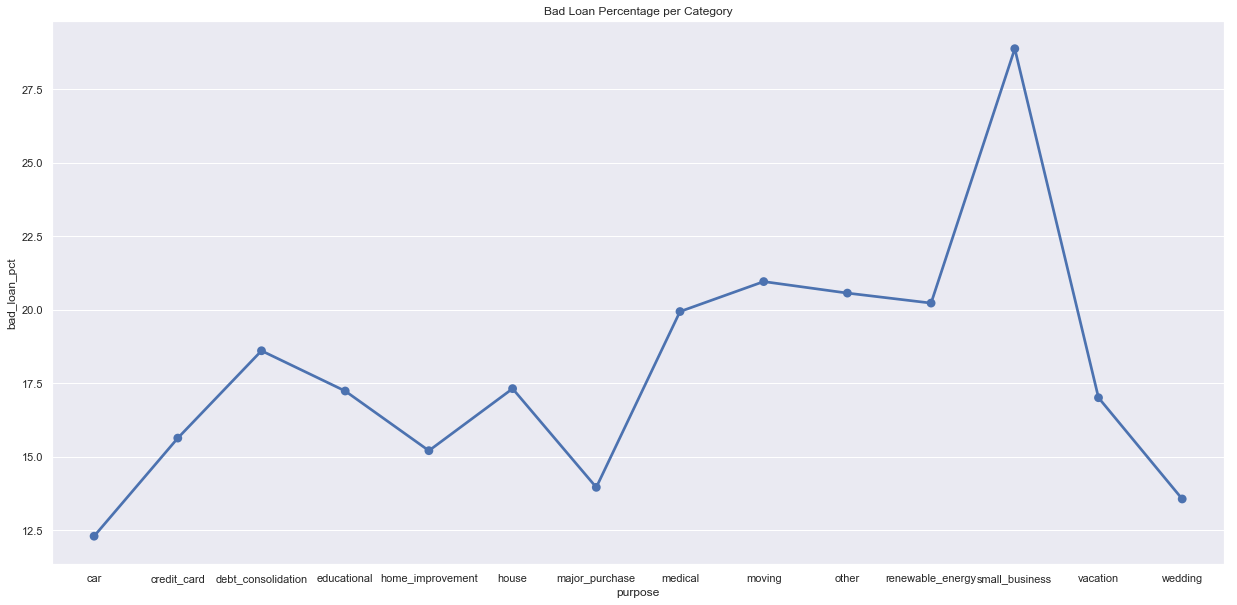

purpose         bad_loan_pct  loan_count
0                  car               12.287        3646
1          credit_card               15.628       50076
2   debt_consolidation               18.602      148363
3          educational               17.231         325
4     home_improvement               15.199       14929
5                house               17.312        1652
6       major_purchase               13.951        6265
7              medical               19.937        2854
8               moving               20.957        2028
9                other               20.565       14277
10    renewable_energy               20.225         267
11      small_business               28.887        4746
12            vacation               17.003        1588
13             wedding               13.555        1955

In [19]:
column_list = ['purpose', 'loan_status']
category_list = np.sort(
    train_eda_obj[column_list[0]].value_counts().index.values).tolist()

get_bad_loan_pct_by_category_01(train_eda_obj, column_list, fig_size=(21, 10))

## Part 2 - Numeric Predictors##

In [20]:
train_eda_num = train_eda.select_dtypes(include=['number']).copy()
train_eda_stats = train_eda_num.drop(columns=['loan_status']).\
                                describe().T.iloc[:, 1:]
train_eda_stats = \
    pd.concat([train_eda_num.drop(columns=['loan_status']).\
                             isnull().sum(), 
               train_eda_stats], axis=1, sort=False)
train_eda_stats.columns = \
    ['null_count'] + train_eda_stats.columns.values.tolist()[1:]

train_eda_stats.round(3)

null_count                 mean                  std  \
annual_inc                 0           72,538.251           58,811.808   
dti                        0               16.544                7.789   
installment                0              418.112              244.933   
int_rate                   0               13.765                4.402   
loan_amnt                  0           13,562.769            8,131.730   
open_acc                   0               10.940                4.891   
pub_rec                    0                0.143                0.436   
revol_bal                  0           15,167.976           18,743.003   
revol_util               199               54.312               24.791   
total_rev_hi_lim       63708           29,709.117           29,517.297   

                                  min                  25%  \
annual_inc                  3,000.000           45,000.000   
dti                             0.000               10.750   
installment                    15.690              239.550   
int_rate                        5.320               10.740   
loan_amnt                     500.000            7,200.000   
open_acc                        0.000                7.000   
pub_rec                         0.000                0.000   
revol_bal                       0.000            5,862.000   
revol_util                      0.000               36.300   
total_rev_hi_lim                0.000           13,300.000   

                                  50%                  75%  \
annual_inc                 62,000.000           87,000.000   
dti                            16.200               21.990   
installment                   365.230              547.550   
int_rate                       13.530               16.550   
loan_amnt                  12,000.000           18,250.000   
open_acc                       10.000               14.000   
pub_rec                         0.000                0.000   
revol_bal                  10,937.000           19,066.500   
revol_util                     55.800               73.900   
total_rev_hi_lim           22,300.000           36,800.000   

                                  max  
annual_inc              8,706,582.000  
dti                            57.140  
installment                 1,424.570  
int_rate                       28.990  
loan_amnt                  35,000.000  
open_acc                       76.000  
pub_rec                        15.000  
revol_bal               1,746,716.000  
revol_util                    892.300  
total_rev_hi_lim        2,013,133.000

We can see that these variables are on many different scales, hence some scaling at the later stage might be in order. Moreover, many of them are skewed to the right. 

Somewhat surprisingly, the following correlation heatmap reveals that most of the column pairs are at most weakly correlated and that there are only two strongly correlated pairs:
- **loan_amnt** and **installment**
- **revolv_bal** and **total_rev_hi_lim**

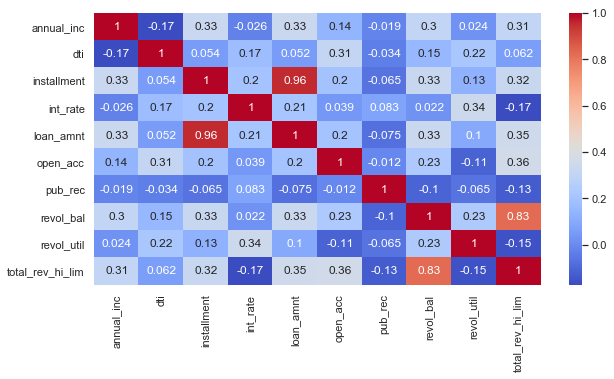

In [21]:
plt.figure(figsize=(10, 5))
sns.heatmap(train_eda_num.drop(columns=['loan_status']).corr(), 
            cmap='coolwarm', annot=True);

The pairplot below reflects these mostly low correlations as the points in the the scatter plots are trully scattered, sometimes all over the palce. On a technical note, in order to make this plot we impute the missing values in **revol_util** (199 missing values) and **total_rev_hi_lim** (63708 missing values).

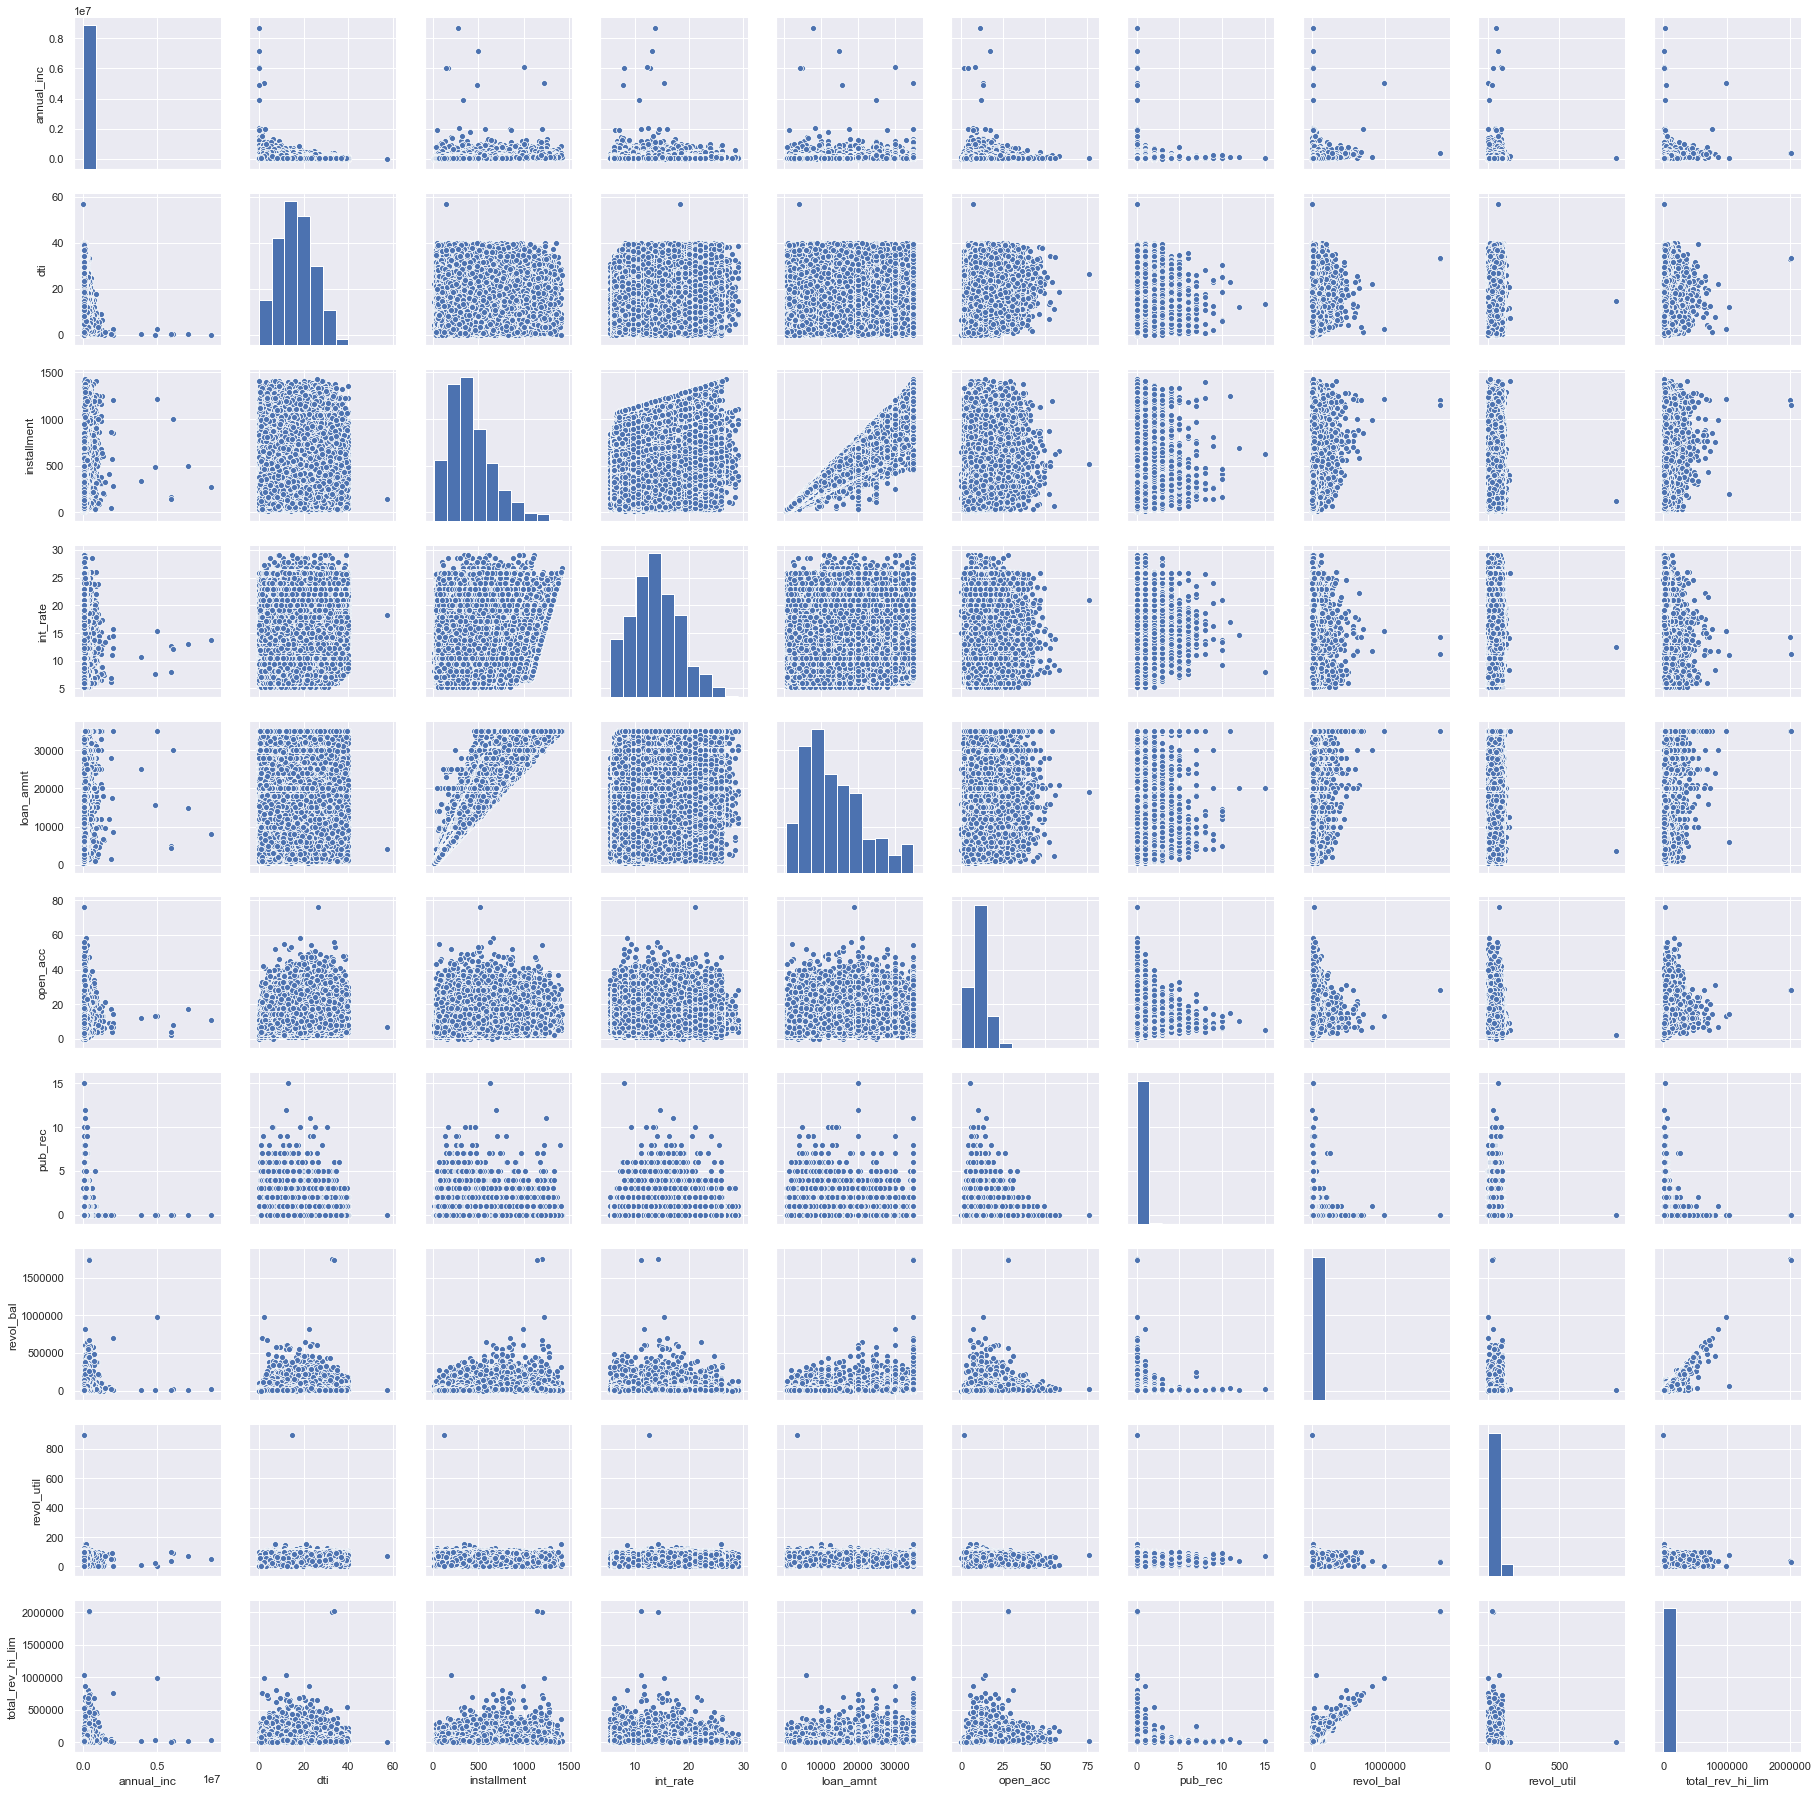

In [22]:
# first, impute total_rev_hi_lim by sub_grade
tmp = train_data.loc[:, ['sub_grade', 'total_rev_hi_lim']].copy()

indx_notnull = tmp['total_rev_hi_lim'].notnull()
tmp_notnull = tmp.loc[indx_notnull, ['sub_grade', 'total_rev_hi_lim']]
subgrade_avg = tmp_notnull.groupby('sub_grade').mean()

for subgrade in subgrade_avg.index:
    indx_subgrade = tmp['sub_grade'] == subgrade
    indx_combined = indx_subgrade & (~indx_notnull)
    
    train_eda_num.loc[indx_combined, 'total_rev_hi_lim'] = subgrade_avg.loc[subgrade, 'total_rev_hi_lim']

# second, perform other imputations
imputer = SimpleImputerWrapper(strategy='mean')
train_eda_num = imputer.fit_transform(train_eda_num)

sns.pairplot(train_eda_num.drop(columns=['loan_status']))
plt.show()

After having imputed the missing data, we can see that for **total_rev_hi_lim** the correlation coeffincients have changed slightly but noticeably.

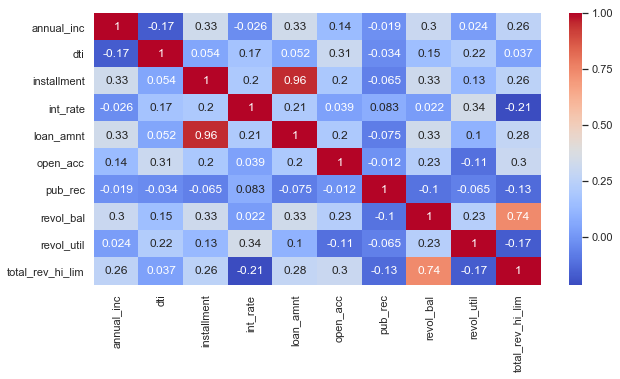

In [23]:
plt.figure(figsize=(10, 5))
sns.heatmap(train_eda_num.drop(columns=['loan_status']).corr(), 
            cmap='coolwarm', annot=True);

Now, we are going to have a closer look at the distribution of these variables. Moreover, we also include the distribution of each variable conditioned on the **loan_status** to see which variables show the highest degree of separation with respect to the target column.

In [24]:
def visualize_distributions(data, titles, method, standardize=True, 
                           percentiles=[[1, 99],[1, 99]]):
   
    def transform_distribution(data, method, standardize=True): 
        power_transf = PowerTransformer(method=method, standardize=standardize)
        transf_data = power_transf.fit(data)  
        lambda_coeff = transf_data.lambdas_    
        transf_data = power_transf.transform(data) 

        return transf_data, lambda_coeff
    
    
    origin_data = data.copy()
    columns = data.columns
    
    transf_col = origin_data[columns[1]].copy().values.reshape(-1, 1)
    transf_col, lambda_coeff = transform_distribution(transf_col, method, standardize)
    transf_data = origin_data.copy()
    transf_data[columns[1]] = transf_col.flatten()
    
    
    print(f'Method: {method}, lambda coefficient: {lambda_coeff}')
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize= (16, 5))
    sns.boxplot(origin_data[columns[1]], ax=ax1)
    ax1.set_title(titles[0])
    sns.boxplot(transf_data[columns[1]], ax=ax2)
    ax2.set_title(titles[1])
    plt.show()

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize= (16, 5))
    sns.distplot(origin_data[columns[1]], ax=ax1)
    ax1.set_title(titles[0])
    sns.distplot(transf_data[columns[1]], ax=ax2)
    ax2.set_title(titles[1])
    plt.show()
    
    
    perc_names = [[str(perc) + '%' for perc in perc_pair] for perc_pair in percentiles]
    percentiles = (np.array(percentiles) / 100).tolist()
    
    print(
        f'Distributions conditioned on {columns[0]} in the following percentile ranges:\
        \nleft: {perc_names[0]}, right: {perc_names[1]}')         
    
    origin_limits = origin_data[columns[1]].describe(percentiles=percentiles[0]).\
                                            T[perc_names[0]]
    transf_limits = transf_data[columns[1]].describe(percentiles=percentiles[1]).\
                                            T[perc_names[1]]
    
    indx_origin_no_extremes = origin_data[columns[1]].between(origin_limits[0], 
                                                              origin_limits[1])
    indx_transf_no_extremes = transf_data[columns[1]].between(transf_limits[0], 
                                                              transf_limits[1])
    
    origin_data_no_extremes = origin_data.loc[indx_origin_no_extremes, :]    
    transf_data_no_extremes = transf_data.loc[indx_transf_no_extremes, :]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize= (16, 5))
    sns.boxenplot(data=origin_data_no_extremes, x=columns[0], y=columns[1], ax=ax1)
    ax1.set_title(titles[0])
    
    sns.boxenplot(data=transf_data_no_extremes, x=columns[0], y=columns[1], ax=ax2)
    ax2.set_title(titles[1])
    plt.show()

**Annual Income** - before removing extreme outliers.

Method: yeo-johnson, lambda coefficient: [0.00000002]


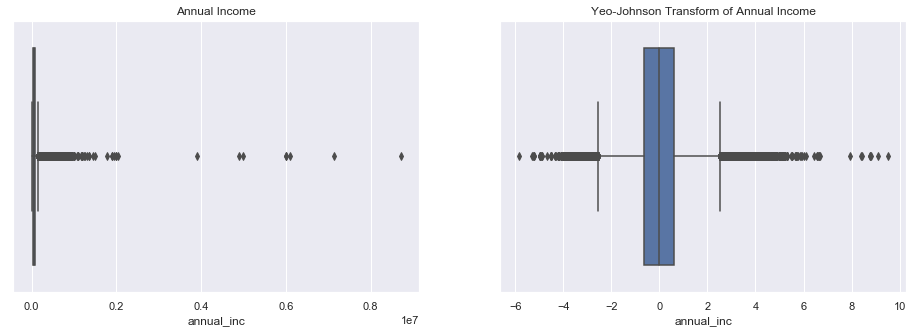

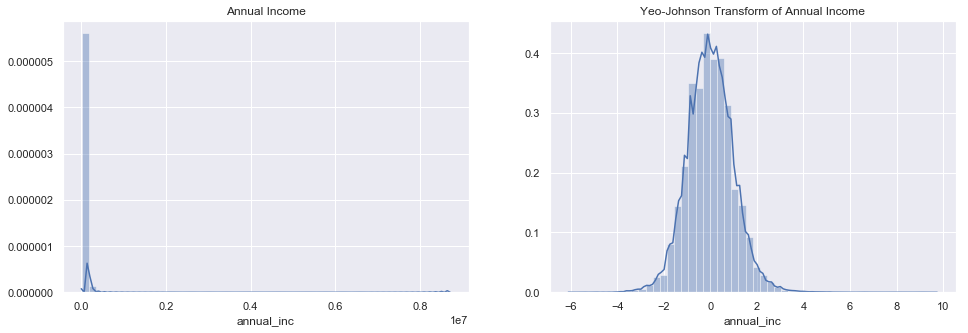

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


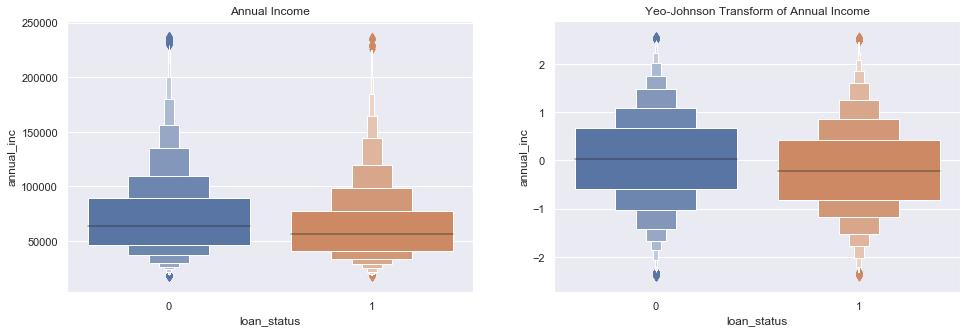

In [25]:
method = 'yeo-johnson'
column = 'annual_inc'
titles = 'Annual Income'
titles = [titles, 'Yeo-Johnson Transform of ' + titles]
data = train_eda_num.loc[:, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

**Annual Income** - after removing extreme outliers (15 observations with **annual_inc** >= 1,500,000).

Method: yeo-johnson, lambda coefficient: [0.]


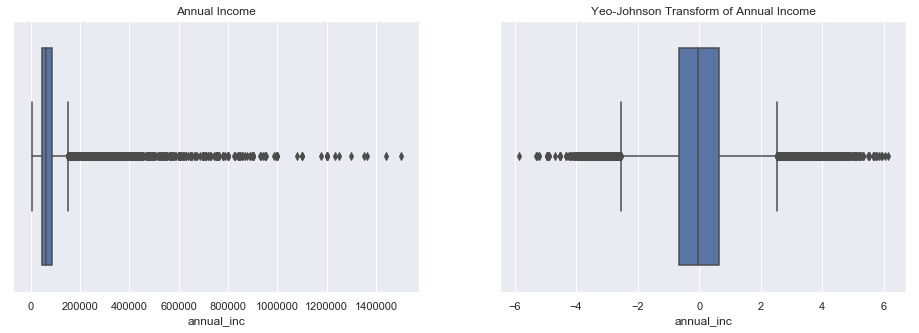

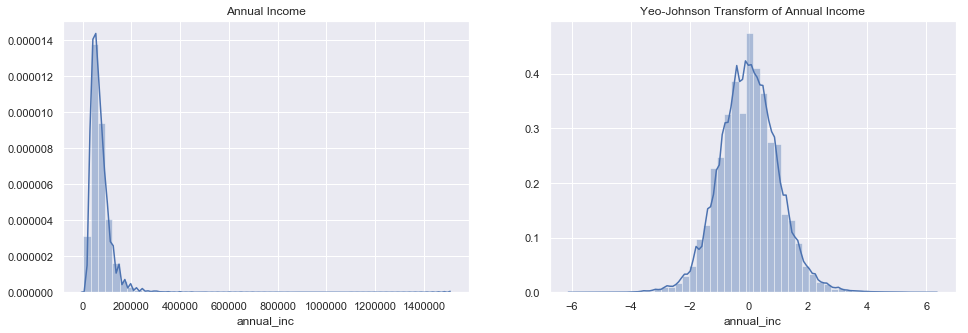

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


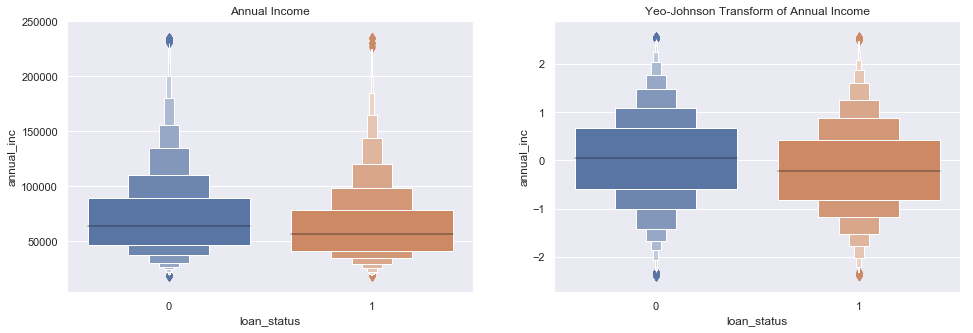

In [26]:
method = 'yeo-johnson'
column = 'annual_inc'
titles = 'Annual Income'
titles = [titles, 'Yeo-Johnson Transform of ' + titles]

indx = train_eda_num[column] <= 1.5 * 10**6
data = train_eda_num.loc[indx, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

In [27]:
dataframe_operations['rows_to_drop'] = list(set(
    dataframe_operations['rows_to_drop'] + train_eda_num.index[~indx].values.tolist()
))
{key: len(val) for key, val in dataframe_operations.items()}

{'columns_to_drop': 53, 'columns_to_engineer': 3, 'rows_to_drop': 60}

**Debt to Income Ratio** - before removing extreme outliers.

Method: yeo-johnson, lambda coefficient: [0.74226086]


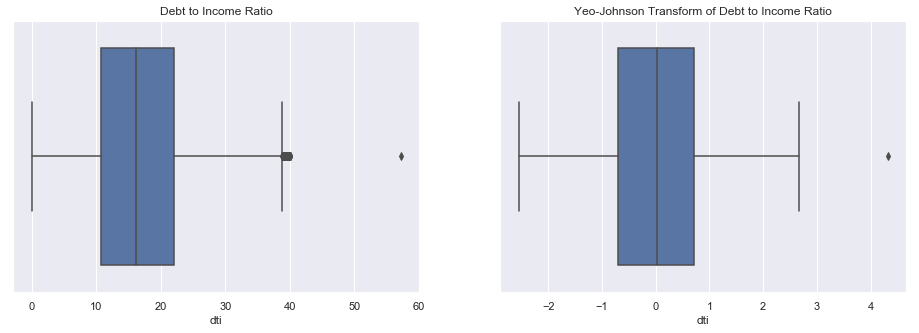

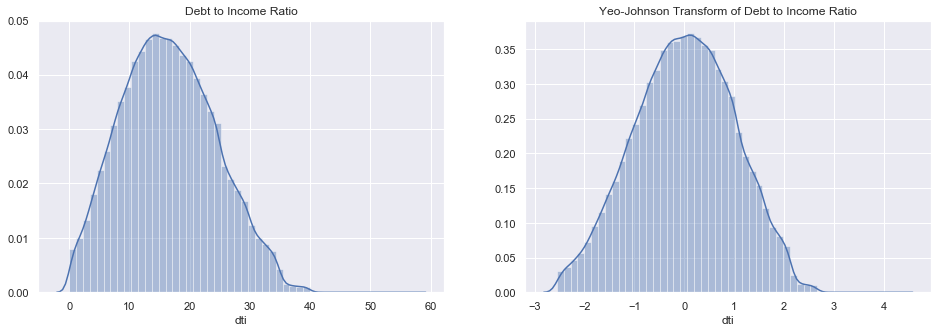

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


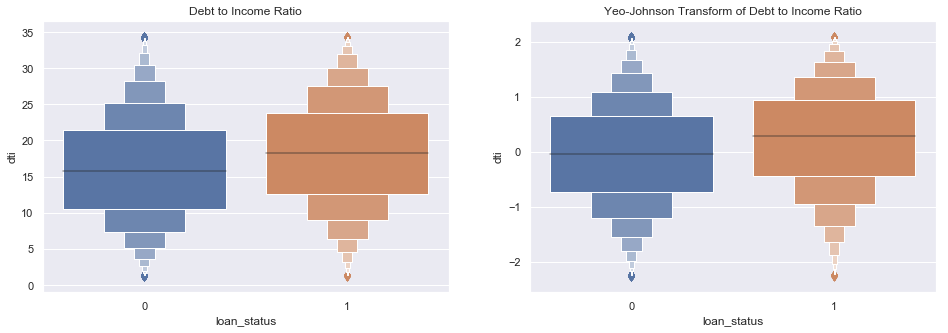

In [28]:
method = 'yeo-johnson'
column = 'dti'
titles= 'Debt to Income Ratio'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]
data = train_eda_num.loc[:, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

**Debt to Income Ratio** - after removing extreme outliers (1 observation with **dti** > 50).

Method: yeo-johnson, lambda coefficient: [0.74239959]


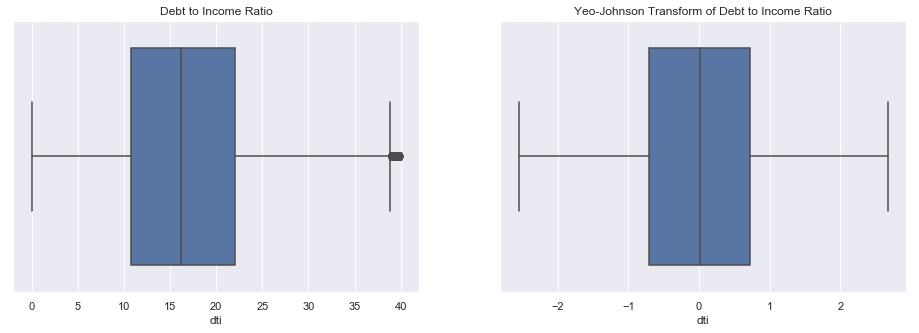

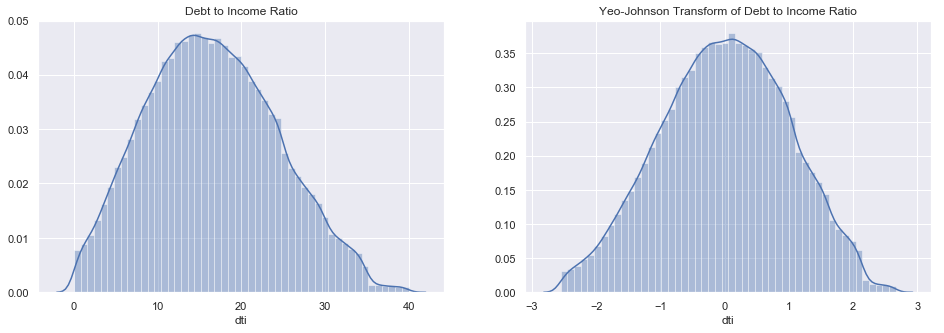

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


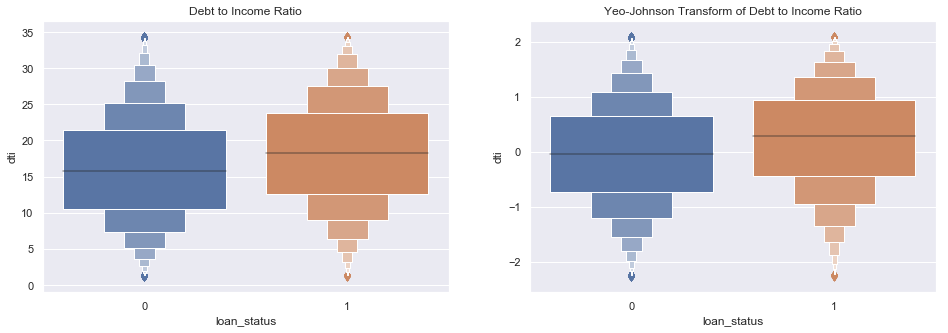

In [29]:
method = 'yeo-johnson'
column = 'dti'
titles= 'Debt to Income Ratio'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]

indx = train_eda_num[column] <= 50
data = train_eda_num.loc[indx, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

In [30]:
dataframe_operations['rows_to_drop'] = list(set(
    dataframe_operations['rows_to_drop'] + train_eda_num.index[~indx].values.tolist()
))
{key: len(val) for key, val in dataframe_operations.items()}

{'columns_to_drop': 53, 'columns_to_engineer': 3, 'rows_to_drop': 61}

**Installment**

Method: yeo-johnson, lambda coefficient: [0.33029728]


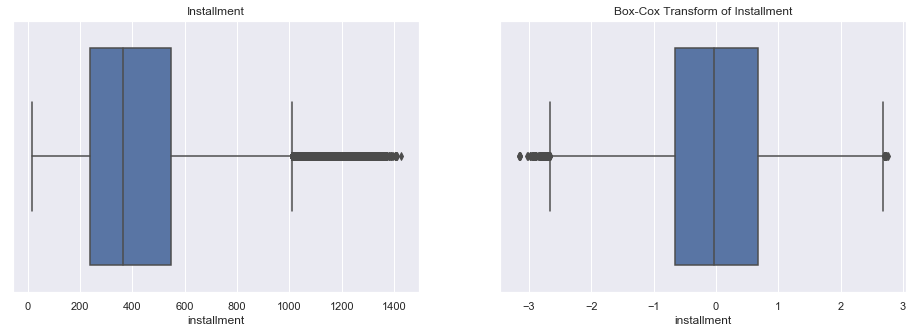

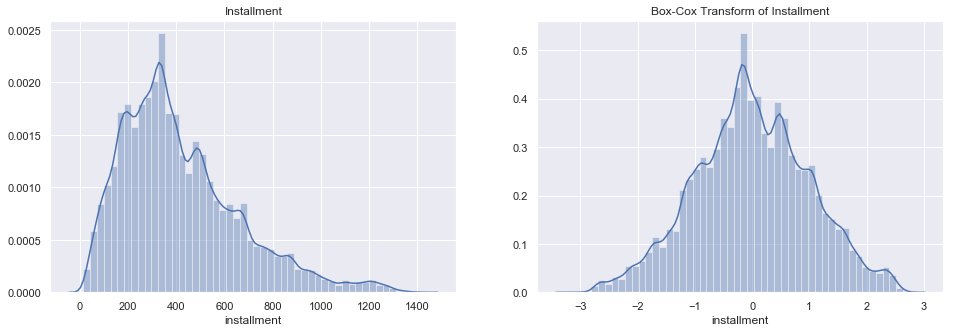

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


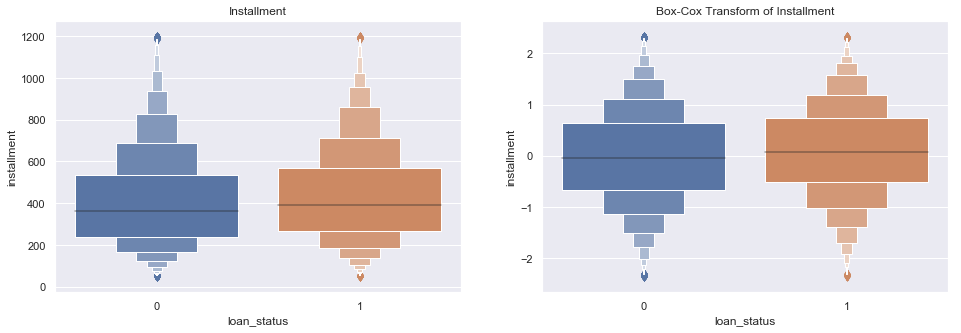

In [31]:
method = 'yeo-johnson'
column = 'installment'
titles= 'Installment'
titles= [titles, 'Box-Cox Transform of ' + titles]
data = train_eda_num.loc[:, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

**Interest Rate**

Method: yeo-johnson, lambda coefficient: [0.46617677]


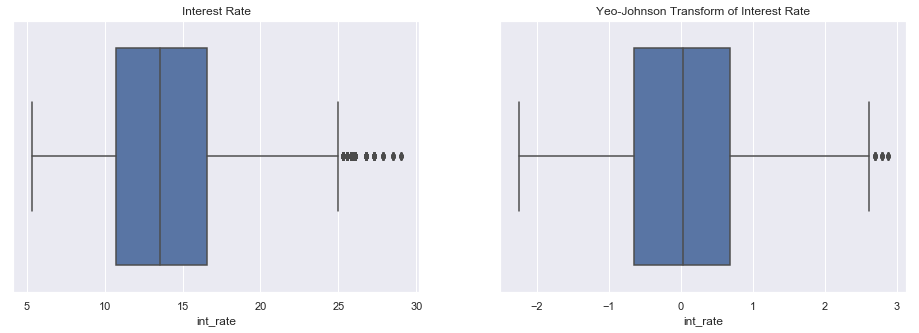

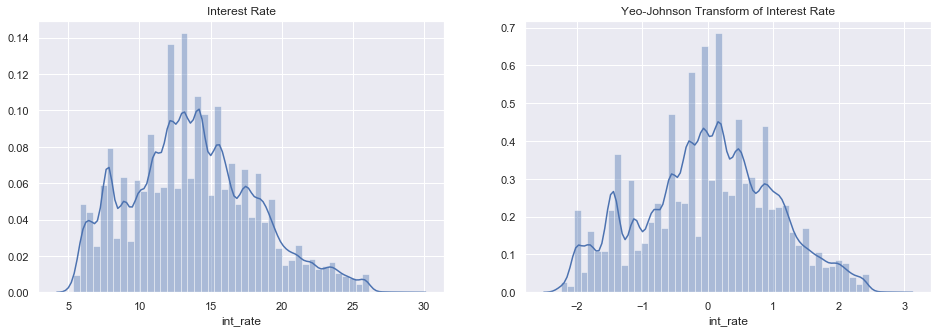

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


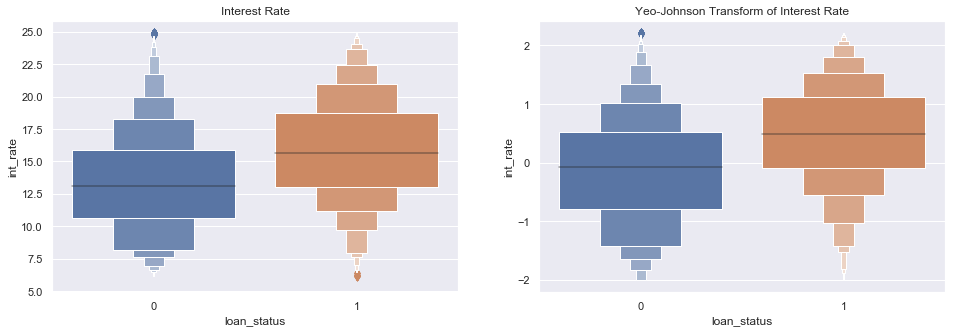

In [32]:
method = 'yeo-johnson'
column = 'int_rate'
titles= 'Interest Rate'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]
data = train_eda_num.loc[:, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

**Loan Amount**

Method: yeo-johnson, lambda coefficient: [0.34351249]


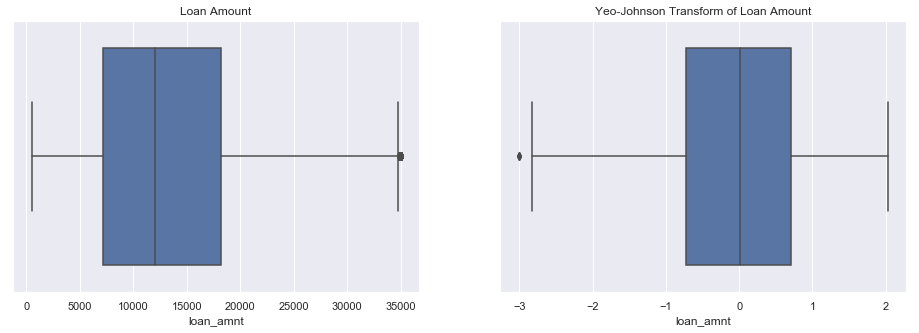

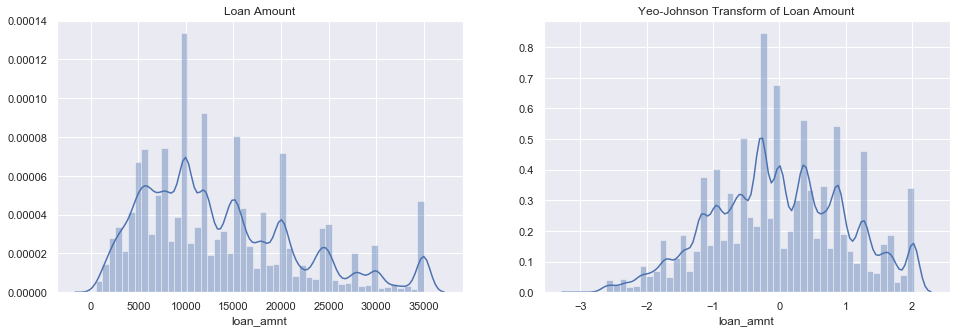

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


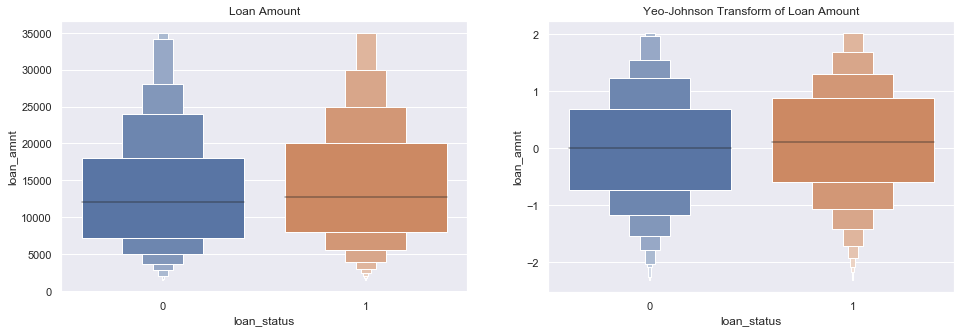

In [33]:
method = 'yeo-johnson'
column = 'loan_amnt'
titles= 'Loan Amount'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]
data = train_eda_num.loc[:, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

**Number of Open Credit Lines** - before removing extreme outliers.

Method: yeo-johnson, lambda coefficient: [0.16151633]


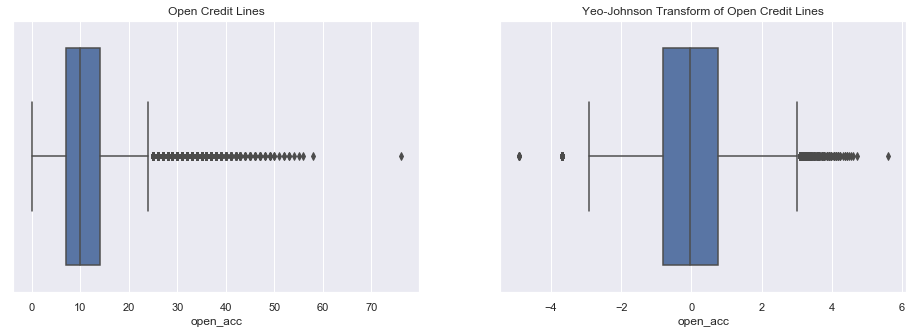

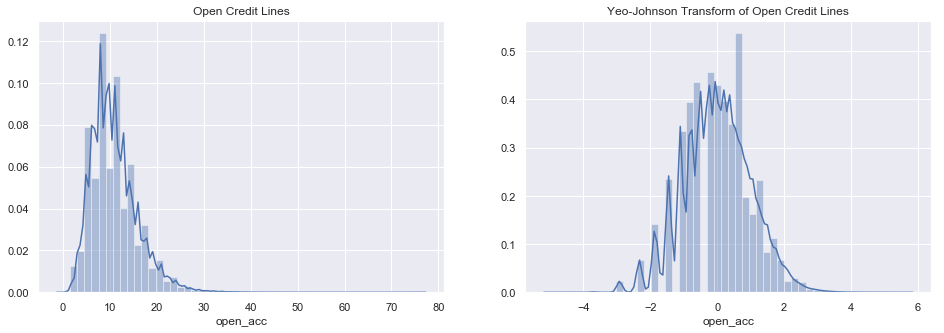

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


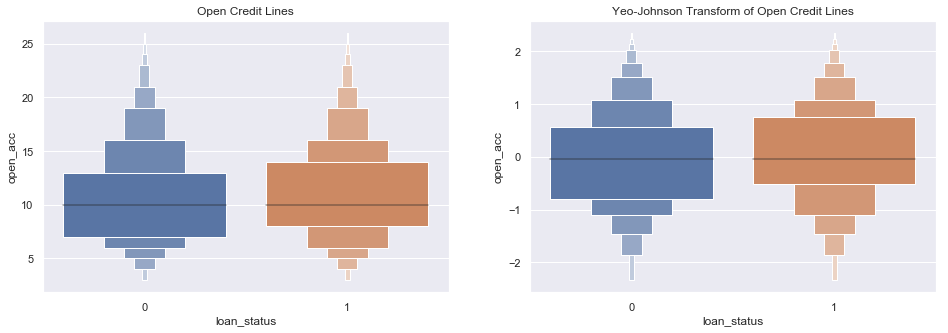

In [34]:
method = 'yeo-johnson'
column = 'open_acc'
titles= 'Open Credit Lines'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]
data = train_eda_num.loc[:, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

**Number of Open Credit Lines** - after removing extreme outliers (1 observation with **open_acc** == 76, other values <= 58).

Method: yeo-johnson, lambda coefficient: [0.16196132]


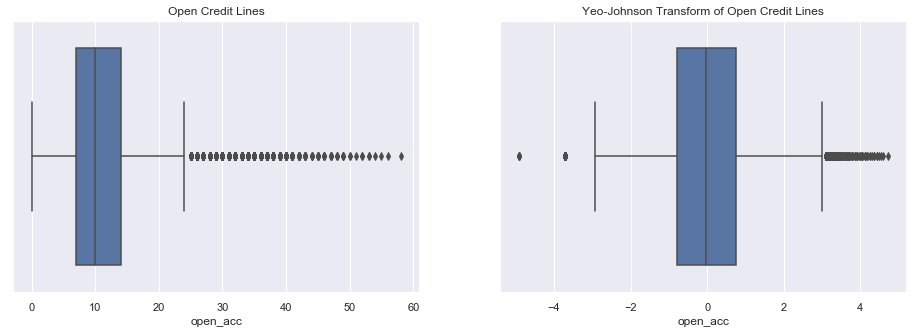

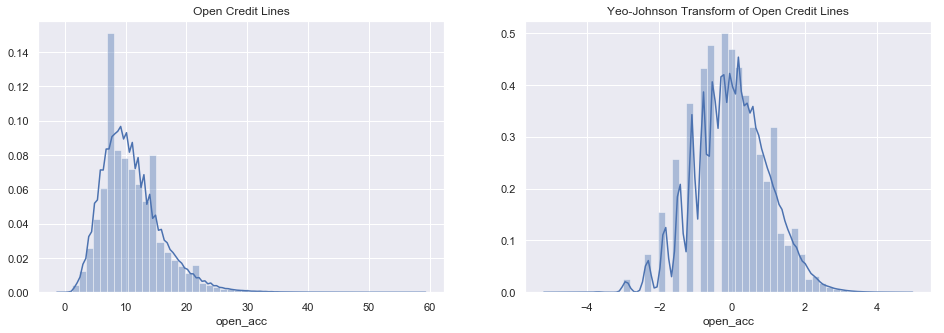

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


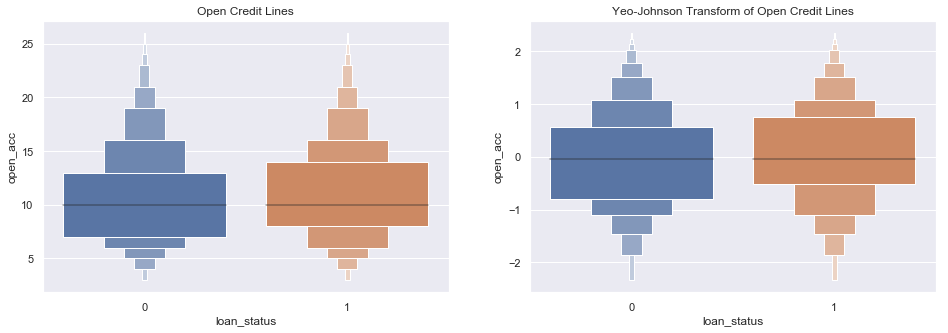

In [35]:
method = 'yeo-johnson'
column = 'open_acc'
titles= 'Open Credit Lines'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]

indx = train_eda_num[column] < 70
data = train_eda_num.loc[indx, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

In [36]:
dataframe_operations['rows_to_drop'] = list(set(
    dataframe_operations['rows_to_drop'] + train_eda_num.index[~indx].values.tolist()
))
{key: len(val) for key, val in dataframe_operations.items()}

{'columns_to_drop': 53, 'columns_to_engineer': 3, 'rows_to_drop': 62}

**Number of Derogatory Public Records** - owing to its structure, this variable is clearly different from the other numeric variables since the substantial majority of its values are zeros and there are merely 3596 values greater than or equal to 2). It is nearly <br> a binary indicator, and somewhat surprisingly, that is roughly the result of shifting its values by 1 to make them positive and then applying the Box-Cox transform (where non-zero numbers of derogatory records are transformed and grouped together).

It can be checked that the modifications introduced by the Yeo-Johnson transform have almost no effect on the structure of this variable.

Method: box-cox, lambda coefficient: [-10.80070022]


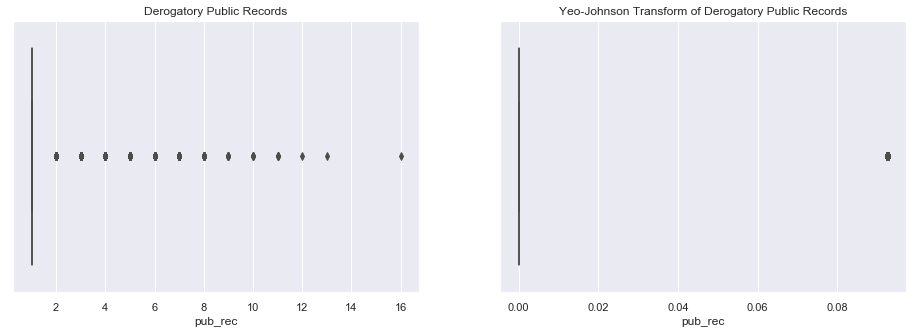

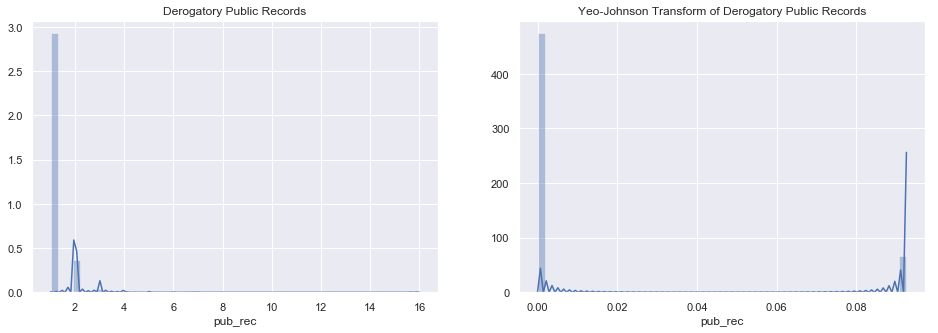

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


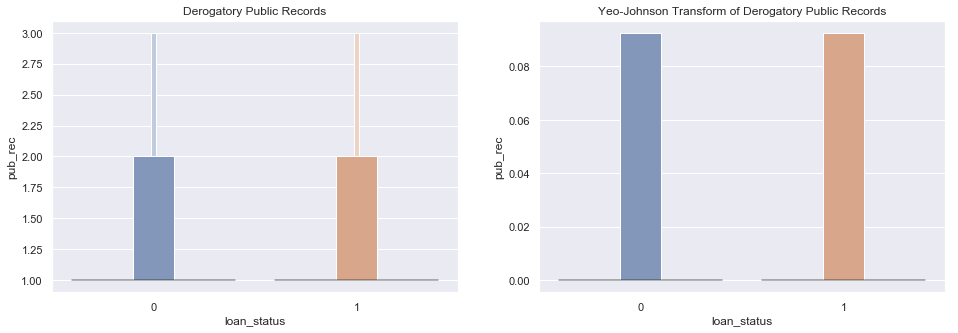

Method: yeo-johnson, lambda coefficient: [-0.]


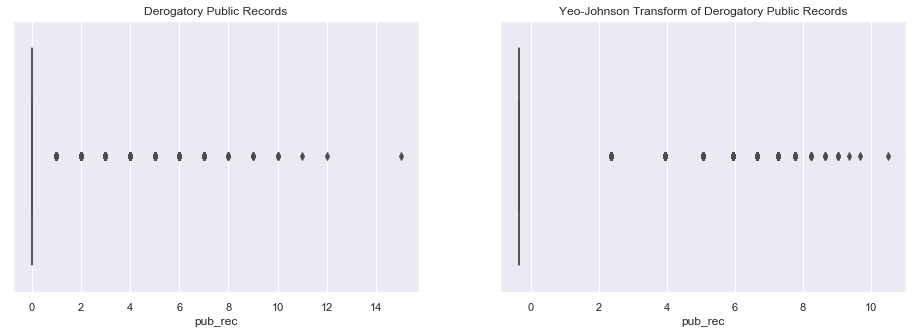

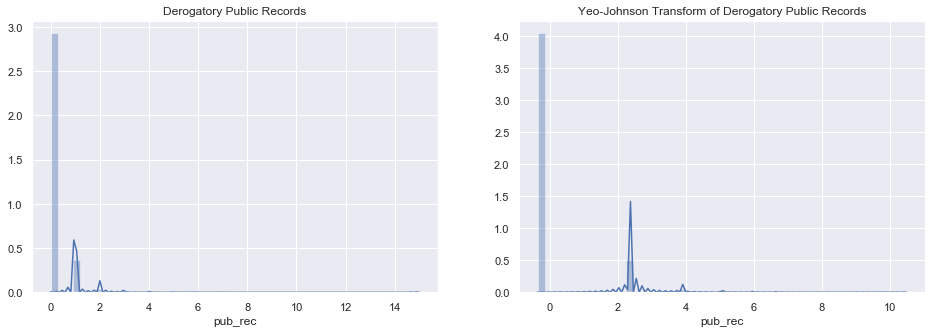

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


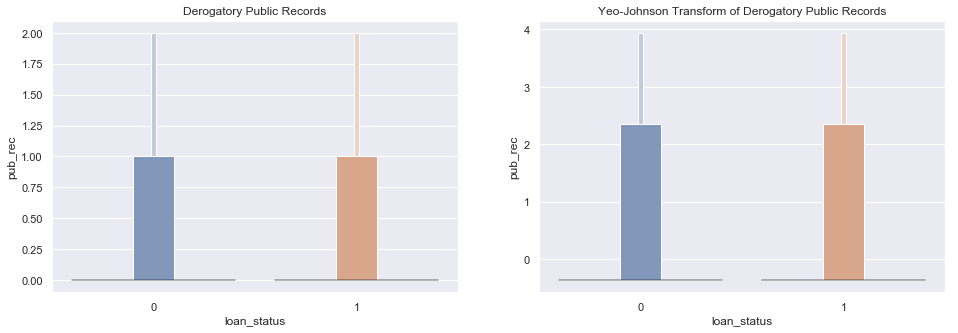

In [37]:
method = 'box-cox'#'yeo-johnson'
column = 'pub_rec'
titles= 'Derogatory Public Records'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]
data = train_eda_num.loc[:, ['loan_status', column]]

data_tmp = data.copy()
data_tmp[column] += 1

visualize_distributions(data=data_tmp, titles=titles, method=method, standardize=False)

method = 'yeo-johnson'
visualize_distributions(data=data, titles=titles, method=method, standardize=True)

**Total Credit Revolving Balance** - before removing extreme outliers.

Method: yeo-johnson, lambda coefficient: [0.28292486]


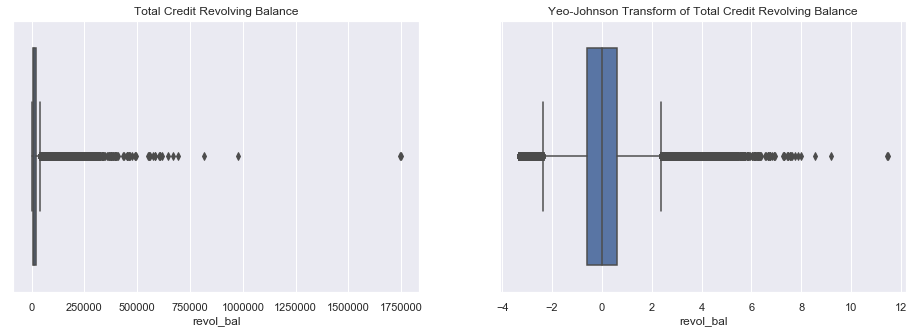

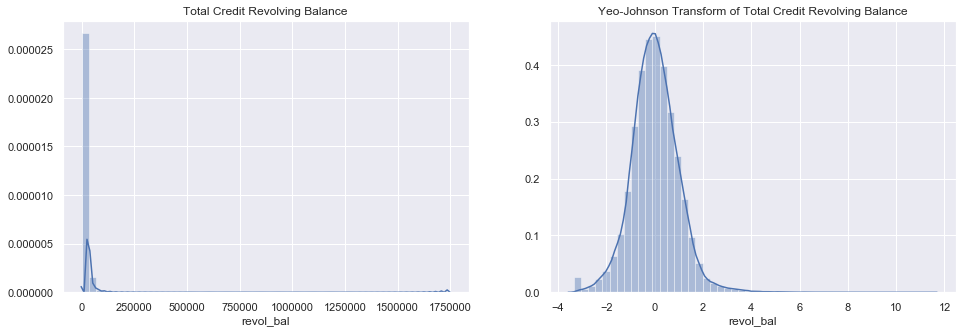

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


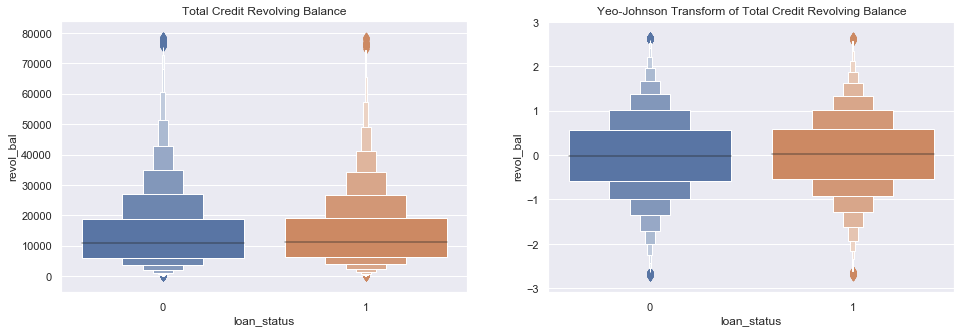

In [38]:
method = 'yeo-johnson'
column = 'revol_bal'
titles= 'Total Credit Revolving Balance'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]
data = train_eda_num.loc[:, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

**Total Credit Revolving Balance** - after removing extreme outliers (4 observations with **revo_bal** > 800,000).

Method: yeo-johnson, lambda coefficient: [0.28434398]


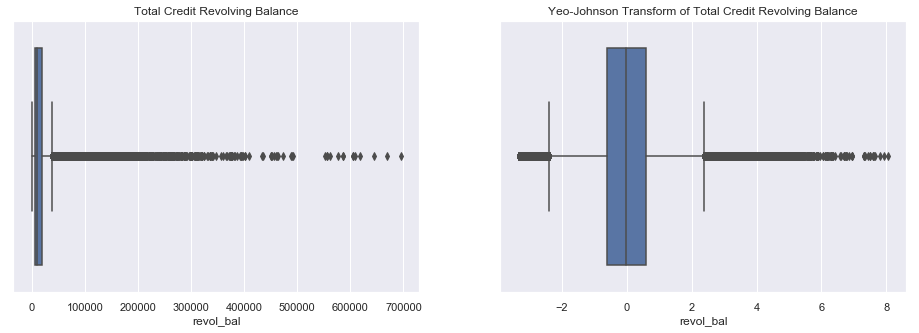

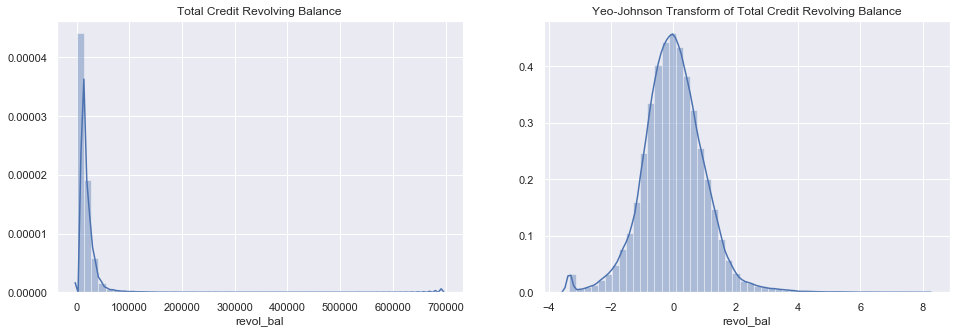

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


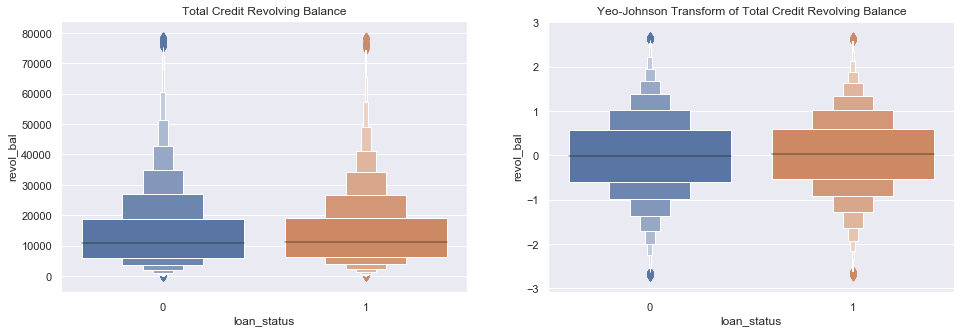

In [39]:
method = 'yeo-johnson'
column = 'revol_bal'
titles= 'Total Credit Revolving Balance'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]

indx = train_eda_num[column] < 800000
data = train_eda_num.loc[indx, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

In [40]:
dataframe_operations['rows_to_drop'] = list(set(
    dataframe_operations['rows_to_drop'] + train_eda_num.index[~indx].values.tolist()
))
{key: len(val) for key, val in dataframe_operations.items()}

{'columns_to_drop': 53, 'columns_to_engineer': 3, 'rows_to_drop': 65}

**Revolving Line Utilization Rate** - before removing extreme outliers.

Method: yeo-johnson, lambda coefficient: [0.95760864]


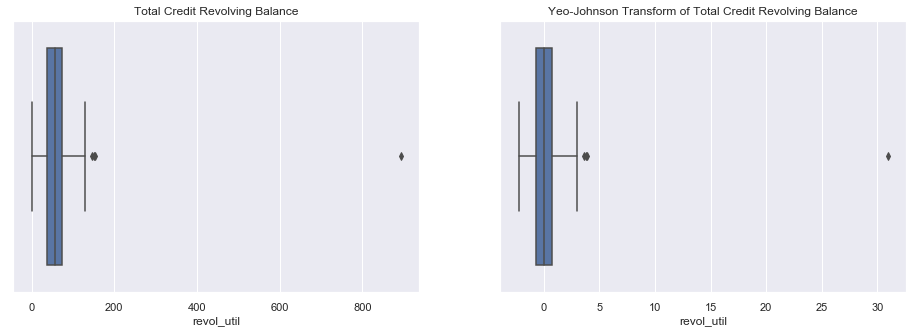

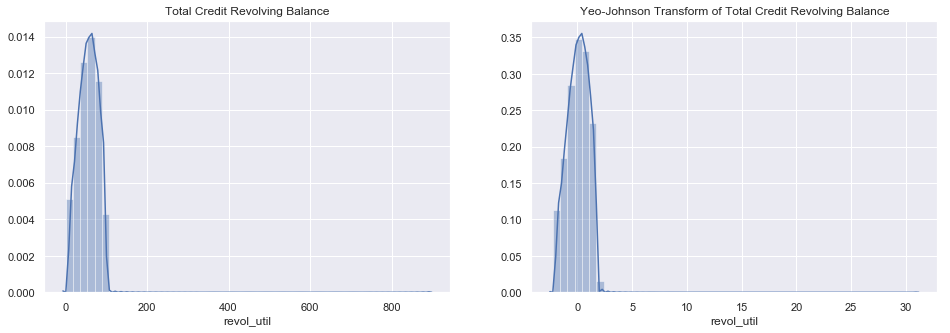

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


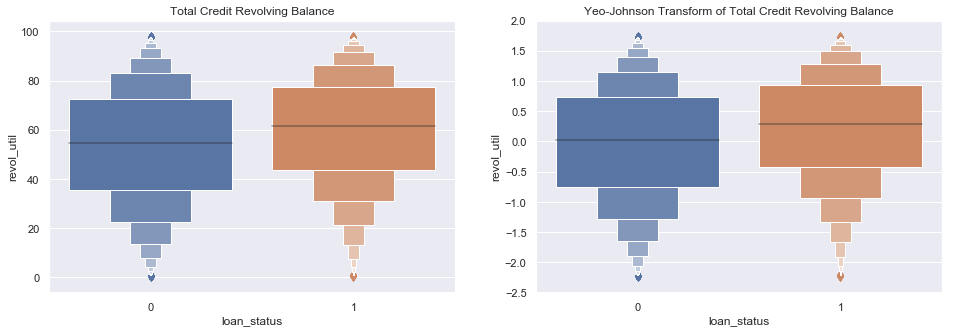

In [41]:
method = 'yeo-johnson'
column = 'revol_util'
titles= 'Total Credit Revolving Balance'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]

indx_notnull = train_eda_num[column].notnull()
data = train_eda_num.loc[indx_notnull, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

**Revolving Line Utilization Rate** - after removing extreme outliers (1 observation with **revo_util** > 800).

Method: yeo-johnson, lambda coefficient: [0.97681488]


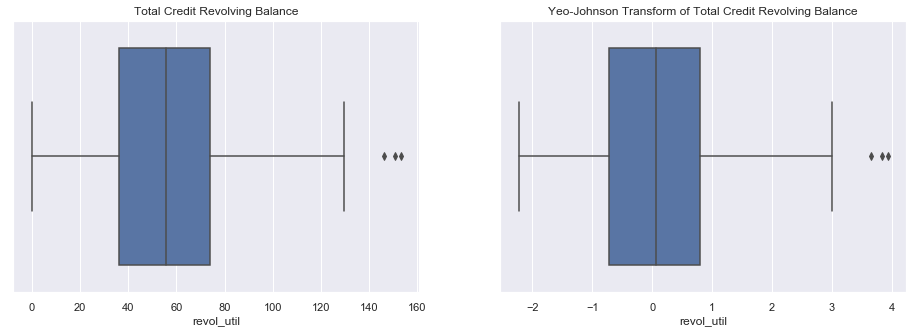

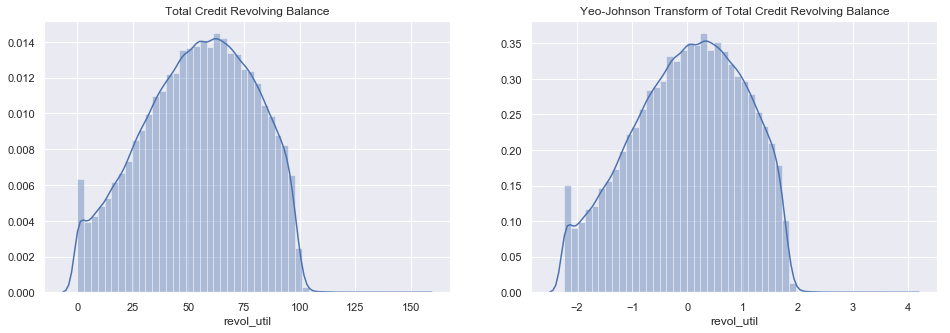

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


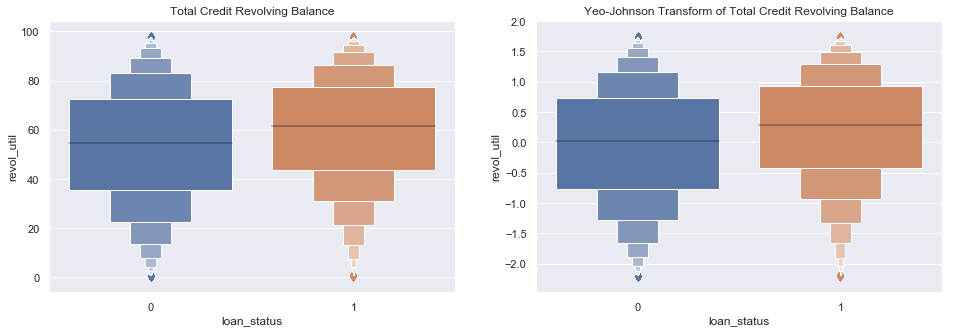

In [42]:
method = 'yeo-johnson'
column = 'revol_util'
titles= 'Total Credit Revolving Balance'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]

indx = train_eda_num.loc[:, column] < 800
data = train_eda_num.loc[indx, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

In [43]:
dataframe_operations['rows_to_drop'] = list(set(
    dataframe_operations['rows_to_drop'] + train_eda_num.index[~indx].values.tolist()
))
{key: len(val) for key, val in dataframe_operations.items()}

{'columns_to_drop': 53, 'columns_to_engineer': 3, 'rows_to_drop': 66}

**Total Revolving High Credit/Credit Limit** - before removing extreme outliers.

Method: yeo-johnson, lambda coefficient: [0.19358006]


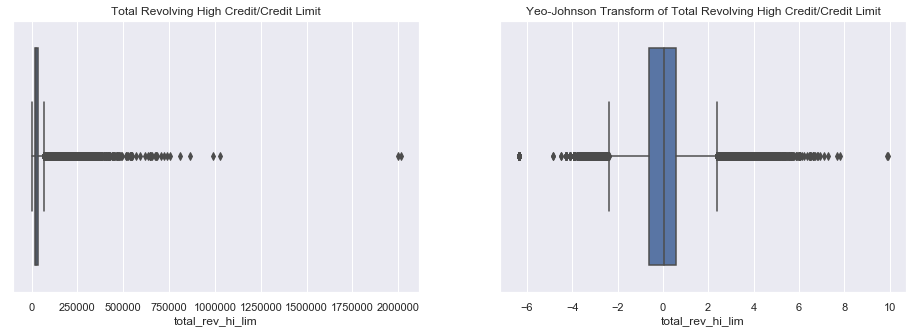

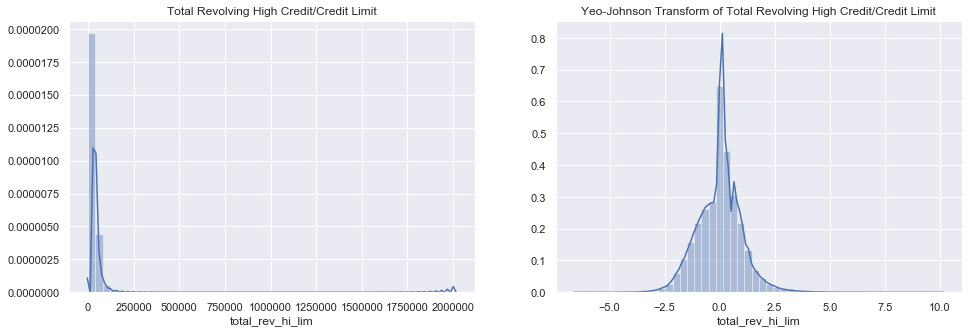

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


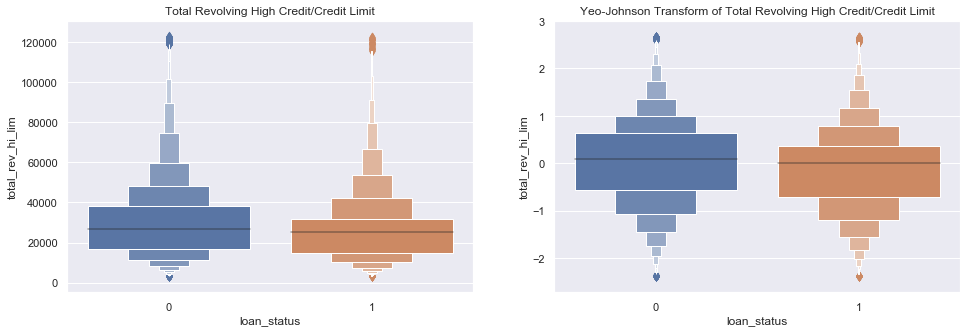

In [44]:
method = 'yeo-johnson'
column = 'total_rev_hi_lim'
titles= 'Total Revolving High Credit/Credit Limit'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]

data = train_eda_num.loc[:, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

**Total Revolving High Credit/Credit Limit** - after removing extreme outliers (6 observations with **total_rev_hi_lim** > 800,000).

Method: yeo-johnson, lambda coefficient: [0.19601661]


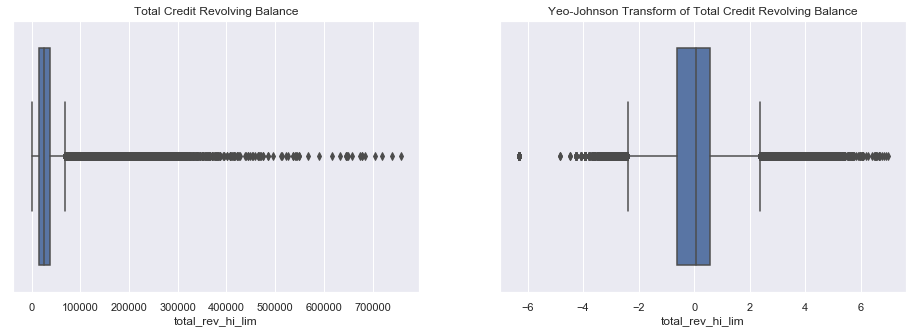

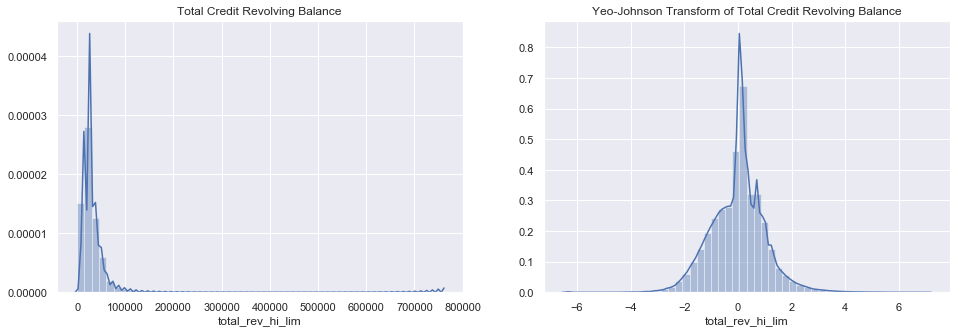

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


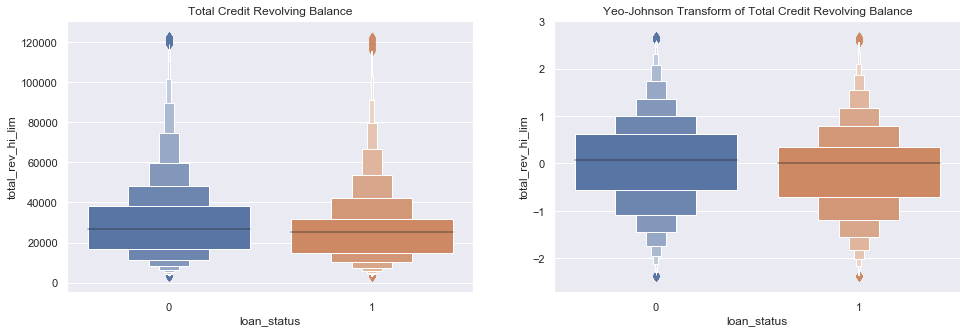

In [45]:
method = 'yeo-johnson'
column = 'total_rev_hi_lim'
titles= 'Total Credit Revolving Balance'
titles= [titles, 'Yeo-Johnson Transform of ' + titles]

indx = train_eda_num.loc[:, column] < 800000
data = train_eda_num.loc[indx, ['loan_status', column]]

visualize_distributions(data=data, titles=titles, method=method)

In [46]:
dataframe_operations['rows_to_drop'] = list(set(
    dataframe_operations['rows_to_drop'] + train_eda_num.index[~indx].values.tolist()
))
{key: len(val) for key, val in dataframe_operations.items()}

{'columns_to_drop': 53, 'columns_to_engineer': 3, 'rows_to_drop': 68}

Now, let's display the pairplot again, this time without the observations to be removed.

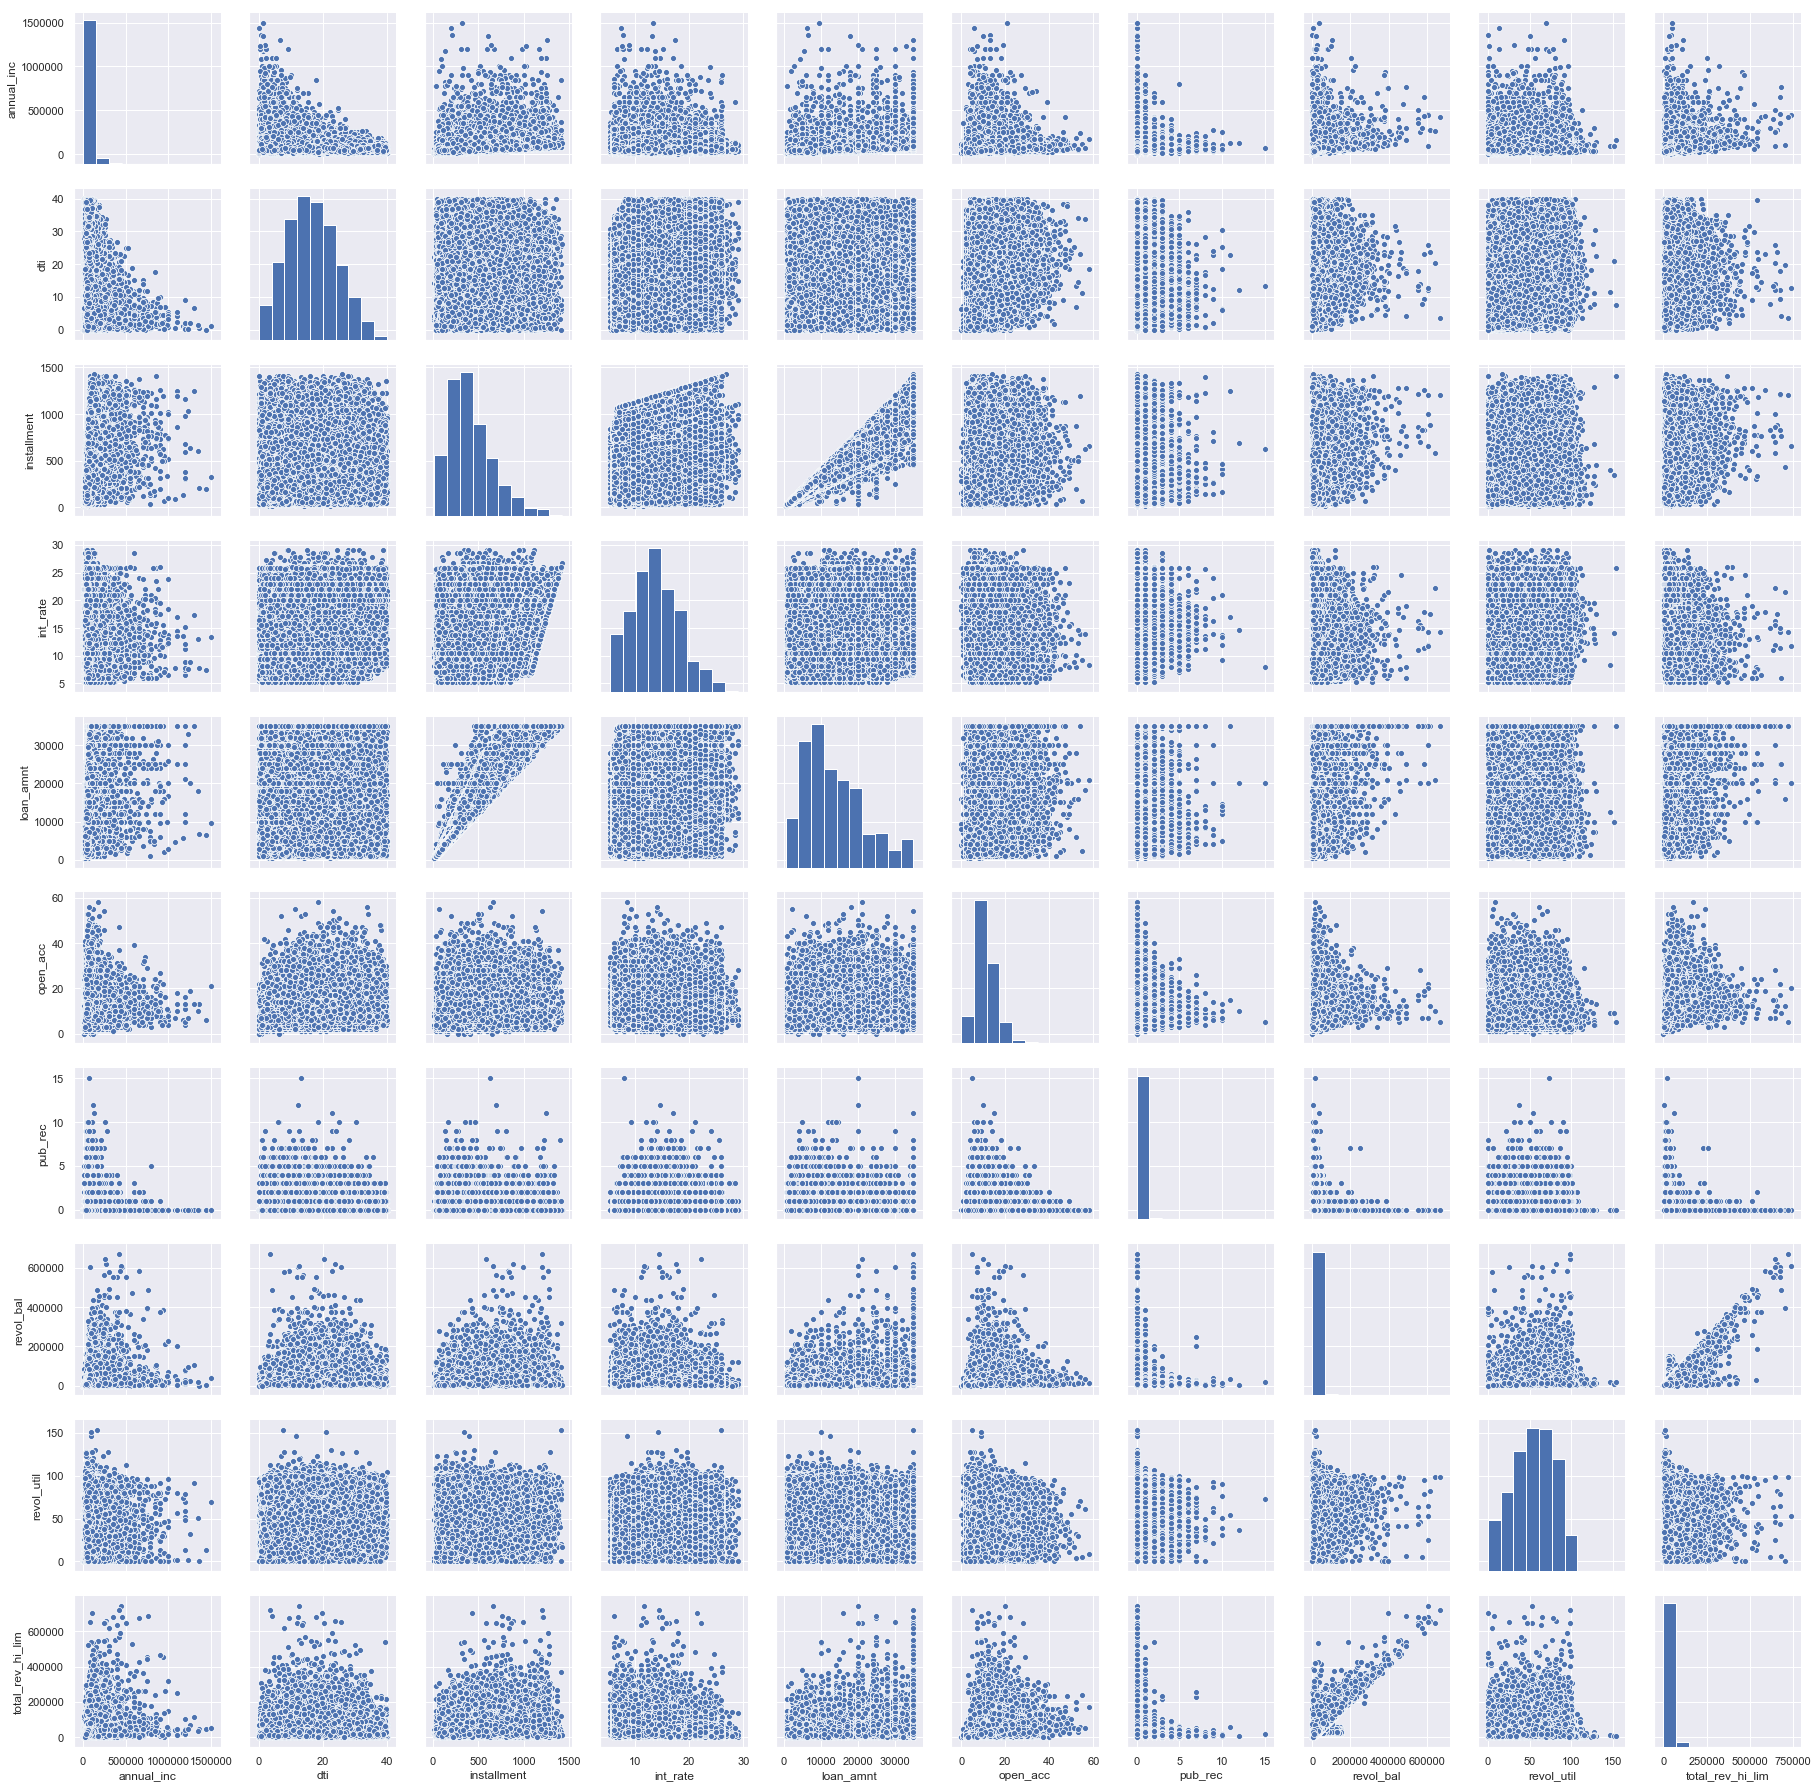

In [47]:
indx = ~train_eda_num.index.isin(dataframe_operations['rows_to_drop'])

sns.pairplot(train_eda_num.drop(columns=['loan_status']).loc[indx, :])
plt.show()

**Feature Engineering - continuous variables**

We convert **emp_length** and **ecl_year** into numeric variables and create two new columns **ratio_1** and **ratio_2** representing rather intuitive quantities: 
- The first ratio is the quotient of i) the amount to pay expressed as the product of the monthly installment amount <br> and the number of such installments and ii) the sum of the loan principal and interest. 
- The second ratio is the quotient with the same numerator as the first one and the denominator being equal to the annual income plus one (to avoid division by zero).

**Employment Length**

Method: yeo-johnson, lambda coefficient: [0.6783493]


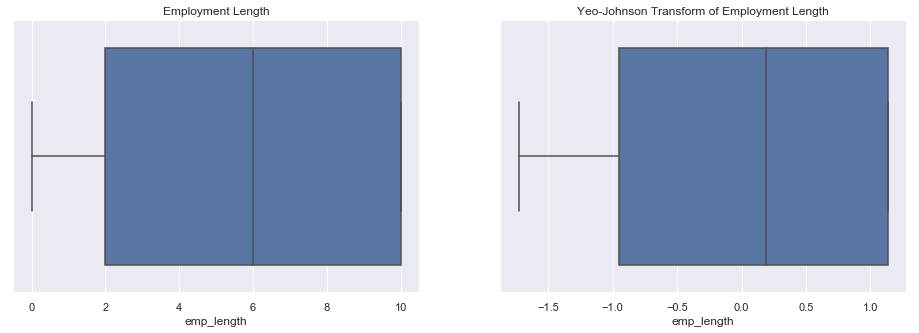

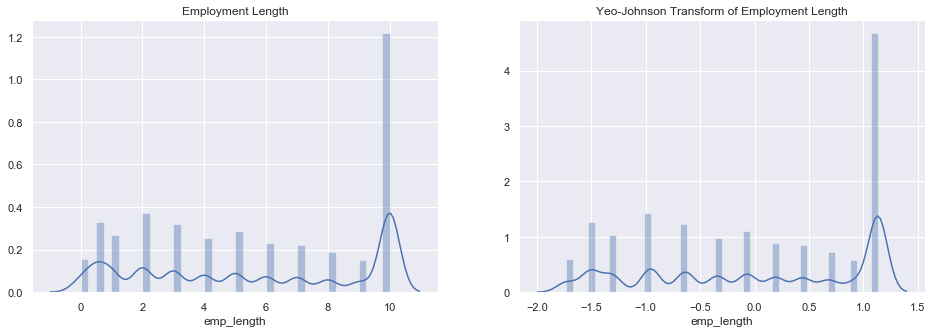

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


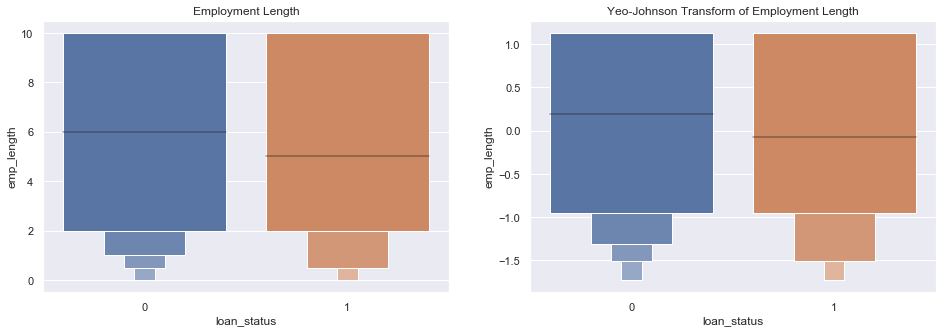

In [48]:
column_list = ['emp_length', 'loan_status']
tmp = train_data.loc[:, column_list].copy()
titles = 'Employment Length'
titles = [titles, 'Yeo-Johnson Transform of ' + titles]

indx_null = tmp['emp_length'].isnull()
tmp.loc[indx_null, 'emp_length'] = 'missing'

category_list = np.sort(tmp['emp_length'].value_counts().index.values).tolist()
category_list = [category_list[-1]] + [category_list[-2]] + [category_list[0]] + \
                 category_list[2:-2] + [category_list[1]]
    
tmp['emp_length'] = pd.Categorical(tmp['emp_length'], categories=category_list)

def convert_emp_len(row):
    if row == 'missing':
        return 0
    elif row == '< 1 year':
        return 0.5
    elif row == '10+ years':
        return 10
    else:
        return int(row[0])

tmp['emp_length'] = tmp['emp_length'].apply(convert_emp_len).astype(np.float)
train_eda_num['emp_length'] = tmp['emp_length'].values

visualize_distributions(data=tmp.loc[:, ['loan_status', 'emp_length']], 
                       titles=titles, method=method)

**Year of Earliest Reported Credit Line Opened**

Method: yeo-johnson, lambda coefficient: [3.41339826]


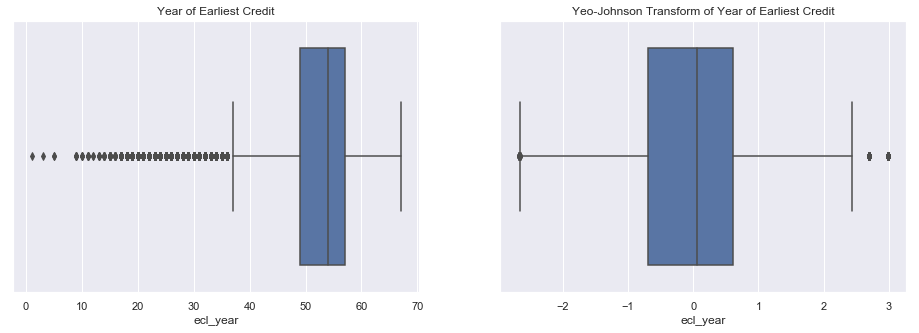

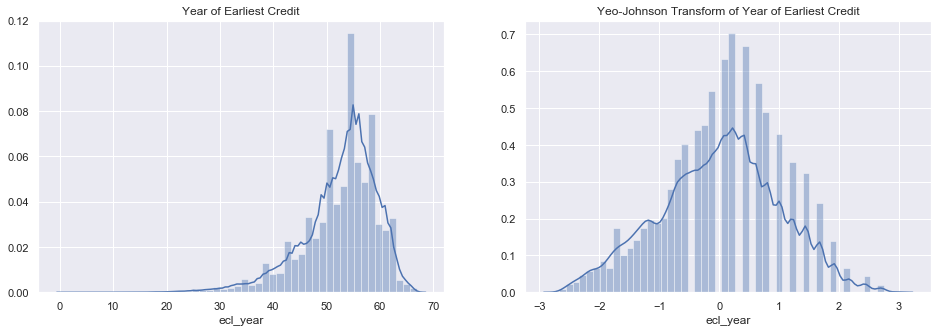

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


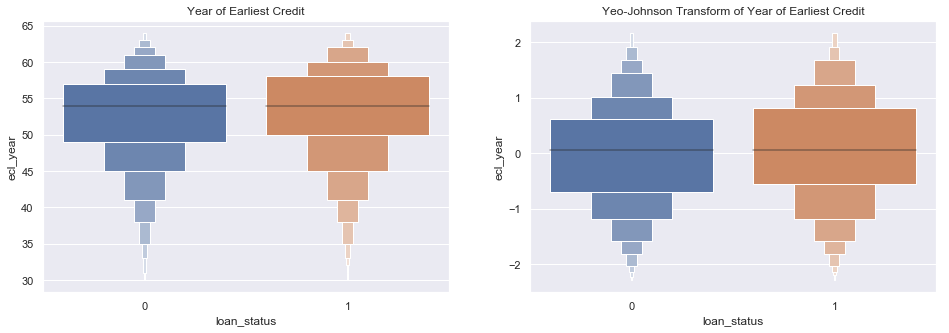

In [49]:
method = 'yeo-johnson'
column = 'ecl_year'
titles = 'Year of Earliest Credit'
titles = [titles, 'Yeo-Johnson Transform of ' + titles]

tmp = pd.DataFrame({'loan_status': train_eda_num['loan_status'], 
                    column: train_eda_obj[column].astype(np.int) - 1945})
tmp.columns = ['loan_status', column]
train_eda_num[column] = tmp[column].values

visualize_distributions(data=tmp, titles=titles, method=method)

**Ratio 1**

Method: yeo-johnson, lambda coefficient: [0.00000004]


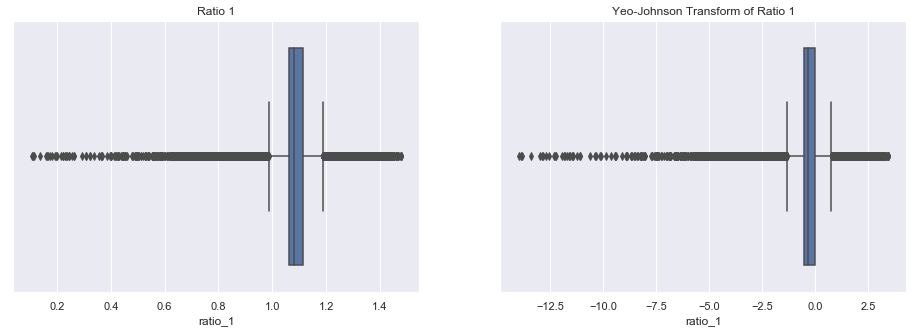

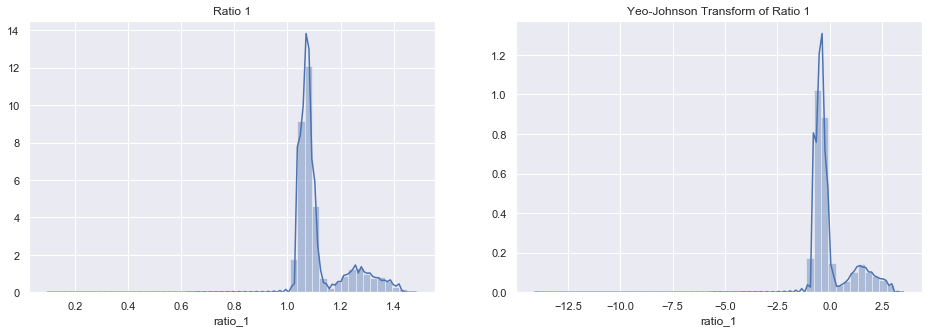

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


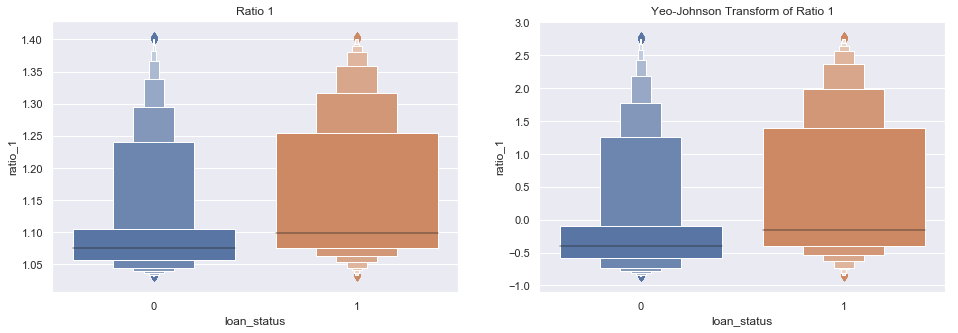

In [50]:
method = 'yeo-johnson'
column = 'ratio_1'
titles = 'Ratio 1'
titles = [titles, 'Yeo-Johnson Transform of ' + titles]

A = train_eda_num['installment'] * train_eda_obj['term'].apply(lambda x: int(x[1:3]))
B = train_eda_num['loan_amnt'] * (1 + train_eda_num['int_rate']/100)

train_eda_num[column] = A / B

data = train_eda_num.loc[:, ['loan_status', column]].copy()

visualize_distributions(data=data, titles=titles, method=method)

**Ratio 2**

Method: yeo-johnson, lambda coefficient: [0.]


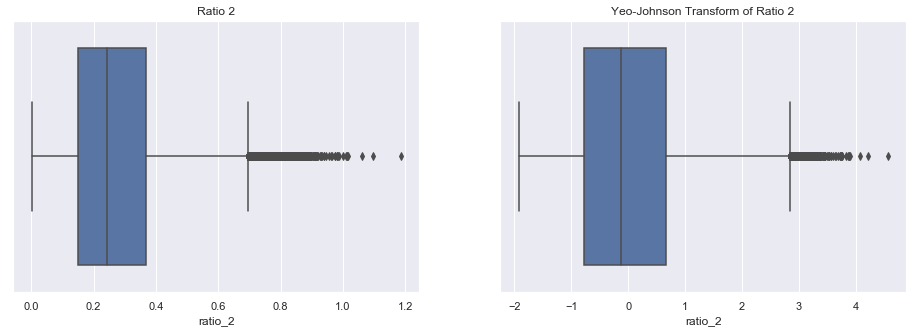

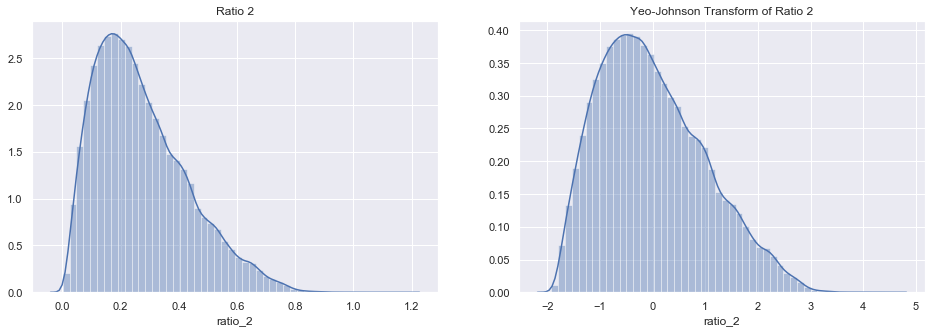

Distributions conditioned on loan_status in the following percentile ranges:        
left: ['1%', '99%'], right: ['1%', '99%']


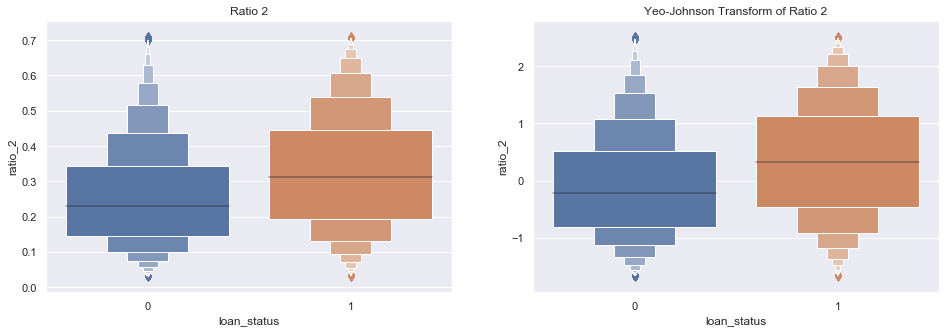

In [51]:
method = 'yeo-johnson'
column = 'ratio_2'
titles = 'Ratio 2'
titles = [titles, 'Yeo-Johnson Transform of ' + titles]

A = train_eda_num['installment'] * train_eda_obj['term'].apply(lambda x: int(x[1:3]))
B = train_eda_num['annual_inc'] + 1

train_eda_num[column] = A / B

data = train_eda_num.loc[:, ['loan_status', column]].copy()

visualize_distributions(data=data, titles=titles, method=method)

We can see that the new variables are not too strongly correlated with the original ones.

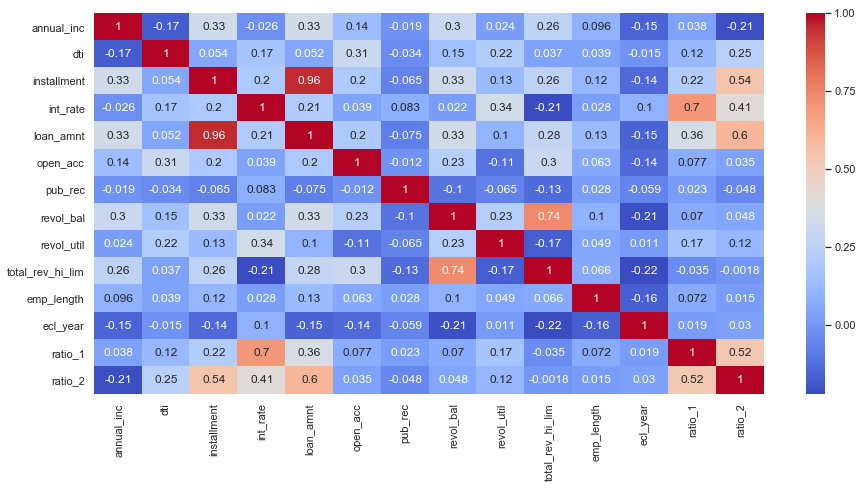

In [52]:
tmp = train_eda_num.select_dtypes(include=['number']).drop(columns=['loan_status'])

plt.figure(figsize=(15, 7))
sns.heatmap(tmp.corr(), cmap='coolwarm', annot=True);

Finally, the pairplot of the selected variables for good measure.

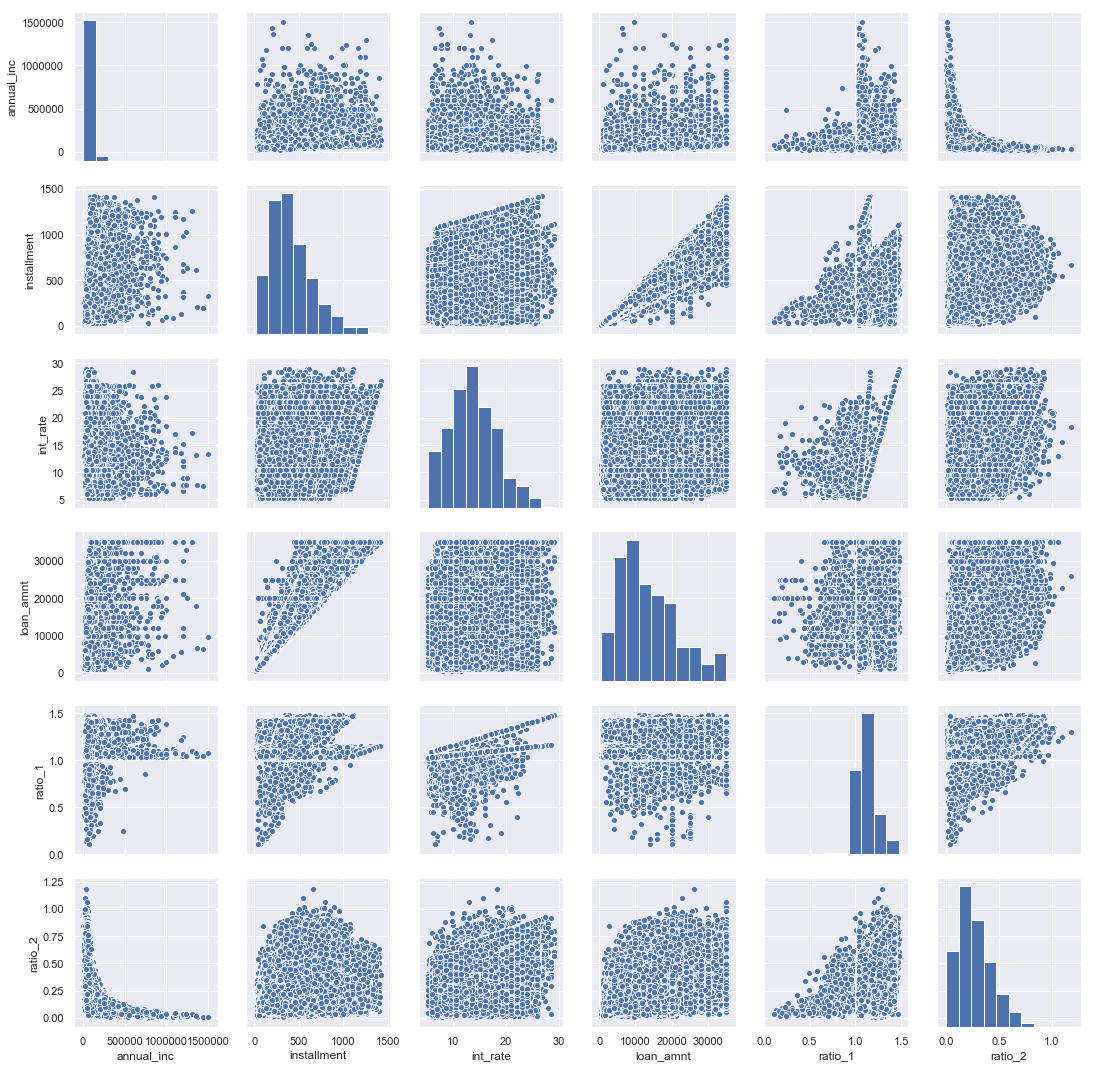

In [53]:
indx = ~tmp.index.isin(dataframe_operations['rows_to_drop'])

sns.pairplot(tmp.loc[indx, ['annual_inc', 'installment', 'int_rate', 
                            'loan_amnt', 'ratio_1', 'ratio_2']])
plt.show()

Now, we can update the dataframe_operations dictionary for further use.

In [54]:
with open('Data/dataframe_operations_02.pkl', 'wb') as file:
    pickle.dump(dataframe_operations, file)